In [64]:
# Import default_timer to compute durations
from timeit import default_timer as timer
Debut=timer() # start time

import numpy as np # import numpy library
import pandas as pd # importing pandas library

# scrapping file paths
from glob import glob

# Allows the use of display() for DataFrames
from IPython.display import display 

from matplotlib import pyplot as plt # import matplot. pyplot to allow figure's plotting
#plt.style.use('bmh') # for better plots


In [60]:
# scrapping data files path
DF_paths_list=sorted(glob("Data/New-Data/full_Datasets_type_I_and_II/*"))
display(DF_paths_list)

['Data/New-Data/full_Datasets_type_I_and_II/Dataset_II_part1.csv',
 'Data/New-Data/full_Datasets_type_I_and_II/Dataset_II_part2.csv',
 'Data/New-Data/full_Datasets_type_I_and_II/Dataset_I_part1.csv',
 'Data/New-Data/full_Datasets_type_I_and_II/Dataset_I_part2.csv']

# I. Importing Dataset type I and II

In [94]:
# loading datasets(these datasets are the outputs of the signal processing pipeline )
Dataset_type_I_part1 = pd.read_csv('./Data/New-Data/full_Datasets_type_I_and_II/Dataset_I_part1.csv')
Dataset_type_I_part2 = pd.read_csv('./Data/New-Data/full_Datasets_type_I_and_II/Dataset_I_part2.csv')
Dataset_type_II_part1= pd.read_csv('./Data/New-Data/full_Datasets_type_I_and_II/Dataset_II_part1.csv')
Dataset_type_II_part2= pd.read_csv('./Data/New-Data/full_Datasets_type_I_and_II/Dataset_II_part2.csv')

print(Dataset_type_I_part1.shape)
print(Dataset_type_I_part2.shape)
print(Dataset_type_II_part1.shape)
print(Dataset_type_II_part2.shape)

print("")

# select parts two be conctenated
frames_I=[Dataset_type_I_part1,Dataset_type_I_part2]
frames_II=[Dataset_type_II_part1,Dataset_type_II_part2]

print(len(frames_I))
print(len(frames_II))

# concatenate each dataframes' parts
Dataset_type_I=pd.concat(frames_I)
Dataset_type_II=pd.concat(frames_II)

print(Dataset_type_I.shape)
print(Dataset_type_II.shape)
print("")
print(Dataset_type_I.head)
print("")
print(Dataset_type_II.head)

# index reset
Dataset_type_I.reset_index(level=0, drop=True, inplace=True)
Dataset_type_II.reset_index(level=0, drop=True, inplace=True)

print("")
print(Dataset_type_I.head)
print("")
print(Dataset_type_II.head)


(5001, 642)
(5398, 642)
(6001, 642)
(6636, 642)

2
2
(10399, 642)
(12637, 642)

<bound method NDFrame.head of       t_body_acc_mean()_X  t_body_acc_mean()_Y  t_body_acc_mean()_Z  \
0                0.002012             0.000431             0.004441   
1               -0.000713            -0.003098             0.000823   
2               -0.000301             0.004025            -0.004280   
3                0.000827            -0.002795             0.004509   
4               -0.001129             0.000569            -0.003437   
...                   ...                  ...                  ...   
5393             0.001128             0.014113            -0.003641   
5394            -0.006005             0.001767            -0.025303   
5395            -0.012493             0.003256            -0.021371   
5396            -0.002722            -0.003546             0.001951   
5397             0.000350            -0.001916            -0.009076   

      t_body_acc_std()_X  t_body_acc_

# II. Datasets Exploration and Exploratory Visualizations

## II.1. Datapoints number per each tuple (user,activity) function:

In [91]:
# This function returns a table includes the number of 
# windows per each tuple(user_id , activity id) included in the dataset 

def num_row_user_act(Df):
    
    user_Ids=sorted(Df['user_Id'].unique()) # extracting and sorting unqiue user ids 
    activity_Ids=sorted(Df['activity_Id'].unique()) # extracting and sorting unqiue activity ids 
    act_columns=['Activity '+str(int(Id)) for Id in activity_Ids ] # defining column names used in output table
    
    if len(activity_Ids)==7: # adapting column names in case the function deals with dataset type III
        act_columns=act_columns[0:6]+['P_Transitions'] 
    
    users_index=['User '+ str(int(Id)) for Id in user_Ids] # defining rows names used in output table
    
    # counting the number of windows per each tuple(user_id,activity_id)
    # store these values in 2D numpy array
    data=np.array([ [len(Df[(Df["user_Id"]== user_ID) &(Df["activity_Id"]==activity_ID)]) 
               for activity_ID in activity_Ids ] for user_ID in user_Ids])
    
    # Create a pandas dataframe from the array above
    win_per_act_per_user=pd.DataFrame(data = data,columns=act_columns,index=users_index)
    
    
    return win_per_act_per_user # returns the dataframe

## II.2. Visualizing Activities Distribution:

In [92]:

##################################################################################
# This function returns the weights activity and visualize the distribution of a column
# This function will be applied only to target columns
def visualize_column(Df,column):
    
    labels= sorted(Df[column].unique()) # extracting and sorting activity unique ids
    Als_dict={ key: len(Df[Df[column]==key]) for key in labels} # counting the number of windows per activity
    data=[Als_dict[key] for key in labels] # sorting these numbers
    
    weights=np.array(data)/float(np.array(data).sum()) # calculating weights of each activity
    
    columns=["Activity "+str(int(key)) for key in labels] # defining columns of weights' table
    
    Df_weights=pd.DataFrame(data=None,columns=columns)# defining an empty dataframe with column names
    Df_weights.loc['Weights']=weights # appending weights row
    
    print("_____ The weights of each activity _____")
    display(Df_weights) # displying weights table
    print("")
    plt.bar(columns,data) # ploting activity distribution
    plt.xlabel('Activity Labels') # set X axis info
    plt.ylabel('Number of Data points') # set Y axis info
    plt.title('Number of Data points per activity') # set the figure's title
    plt.show() # showing the figure

## Data Exploration PipeLine

In [96]:
def data_exploration_pipeline(Dataset,typ,outliers):
    # inputs:
    #        Dataset: a pandas dataframe can be a full dataset (I or II), 
    #               cleaned dataset(I or II or III), outliers dataset (I or II)
    
    #        typ    : integer type of the dataset possible values: 1(for dataset type I), 2(for type II) or 3 (for type III)
    #        outliers: Boolean if true dataset we are dealing with is an outlier dataset(contain outlier values)         
    
    # columns names of the dataset
    columns=Dataset.columns
    
    if not outliers:  # in case we are not dealing with outliers datasets  
        # Adapting the dataset name switch the typ
        if typ==1:
            Dataset_name="Dataset type I "
        if typ==2:
            Dataset_name="Dataset type II "
        if typ==3:
            Dataset_name="Dataset type III "
    else:# in case we are dealing with outliers
        
        # adapting the dataset names switch the case
        if typ==1:
            Dataset_name="Outliers of Dataset type I "
        if typ==2:
            Dataset_name="Outliers of Dataset type II "
    
    # general info about the dataset: number of rows and columns
    print(  Dataset_name+'has a shape of: '+ str(Dataset.shape[0]) +' rows and '+str(Dataset.shape[1])+' columns')
    print("")
    print("")    
    print("")
    
    if not outliers: # in case dataset is not an outlier dataset
        print("The first 3 rows of "+Dataset_name +":")
        display(Dataset.iloc[0:3]) # display the first 3 rows
        print("")
        print("")    
        print("")
        print("rows 500, 501, 502 of "+Dataset_name +":")
        display(Dataset.iloc[500:503]) # display rows 500,501 and 502
        print("")
        print("")    
        print("")
        print("Description of the 10 first features:")
        display(Dataset.describe()[columns[0:10]]) # statistics of the first ten time domain features
        print("")
        print("")    
        print("")
        print("Description of the 10 first frequency features:")
        display(Dataset.describe()[columns[265:275]]) # statistics of the first ten frequency domain features
        print("")
        print("")    
        print("")
    Stats= num_row_user_act(Dataset)# generate number of windows per each tuple (user,activity)
    print("Number of windows per user and per each activity:")
    display(Stats)# display the table
    print("")
    print("")    
    print("")
    print("Statistics of table above:")
    display(Stats.describe())# table's statics
    print("")
    print("")    
    print("")
    visualize_column(Dataset,"activity_Id") # visualize activity distribution of the dataset 

Dataset type I has a shape of: 10399 rows and 642 columns



The first 3 rows of Dataset type I :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
0,0.002012,0.000431,0.004441,0.004025,0.013983,0.027372,0.004725,0.019132,0.025280,0.010209,...,104.954731,1.070749,1.431913,2.116867,1.431211,0.152888,1.692169,1.478284,5.0,1.0
1,-0.000713,-0.003098,0.000823,0.004491,0.012449,0.022660,0.004168,0.014039,0.022765,0.009030,...,109.749747,1.652580,1.856253,1.210803,1.753009,0.149532,1.687352,1.477548,5.0,1.0
2,-0.000301,0.004025,-0.004280,0.004866,0.009352,0.016821,0.005255,0.010157,0.020681,0.011261,...,110.445137,1.776612,1.159471,1.763958,2.682216,0.157004,1.696158,1.476770,5.0,1.0





rows 500, 501, 502 of Dataset type I :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
500,-0.002612,0.001936,-0.001619,0.189157,0.185271,0.183038,0.143988,0.175647,0.132513,0.591082,...,91.491078,2.062117,2.679764,1.156250,2.219589,0.678680,1.872693,2.156621,2.0,2.0
501,-0.004327,0.000869,-0.001459,0.182054,0.194016,0.194199,0.143727,0.216793,0.127459,0.579079,...,78.446975,2.215386,0.809965,1.322636,1.171731,0.683628,1.868445,2.164451,2.0,2.0
502,0.000866,-0.002031,-0.002663,0.184468,0.172920,0.201545,0.138529,0.199514,0.139102,0.579079,...,74.697056,0.646230,2.160502,2.508356,0.320551,0.689991,1.858852,2.176837,2.0,2.0





Description of the 10 first features:


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X
count,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000
mean,0.000181,-0.000253,0.000043,0.128598,0.085825,0.071912,0.120879,0.077916,0.065929,0.316530
std,0.009100,0.006948,0.006990,0.139670,0.081466,0.068746,0.132093,0.073289,0.060767,0.345820
min,-0.047488,-0.038424,-0.047545,0.001815,0.002281,0.003507,0.001536,0.002089,0.002521,0.003151
25%,-0.003148,-0.003659,-0.003376,0.009211,0.012132,0.011688,0.009886,0.012923,0.012555,0.018161
50%,0.000080,-0.000127,-0.000052,0.023508,0.031908,0.029514,0.024822,0.032945,0.031158,0.053550
75%,0.003343,0.003268,0.003301,0.242569,0.159502,0.128384,0.229137,0.141543,0.116171,0.615332
max,0.046679,0.036071,0.045893,0.635720,0.341042,0.353751,0.655178,0.339054,0.364321,1.226526





Description of the 10 first frequency features:


,f_body_acc_mean()_X,f_body_acc_mean()_Y,f_body_acc_mean()_Z,f_body_acc_std()_X,f_body_acc_std()_Y,f_body_acc_std()_Z,f_body_acc_mad()_X,f_body_acc_mad()_Y,f_body_acc_mad()_Z,f_body_acc_max()_X
count,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000,10399.000000
mean,0.745333,0.551104,0.452787,1.249054,0.799908,0.675420,0.329930,0.261509,0.240862,7.971712
std,0.813909,0.550454,0.453078,1.358776,0.742929,0.637685,0.381239,0.290441,0.273881,8.898660
min,0.015014,0.019182,0.028569,0.013632,0.019417,0.025974,0.006711,0.006004,0.011886,0.051908
25%,0.045469,0.057965,0.061821,0.095906,0.127022,0.120482,0.019641,0.021335,0.030041,0.677059
50%,0.125650,0.167383,0.150461,0.243477,0.327786,0.308786,0.062413,0.062228,0.065755,1.728940
75%,1.435898,1.051040,0.828692,2.324872,1.468506,1.171809,0.609422,0.486900,0.421265,14.473738
max,3.719777,2.372634,2.425497,6.200617,3.282382,3.366875,2.225230,1.859802,2.177071,43.848146





Number of windows per user and per each activity:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
User 1,95,53,49,47,55,48
User 2,59,48,47,46,55,49
User 3,58,59,49,51,63,63
User 4,60,52,45,48,56,52
User 5,56,47,47,43,57,51
User 6,57,51,48,56,58,56
User 7,57,51,47,47,54,50
User 8,47,41,38,45,57,55
User 9,52,49,42,53,49,54
User 10,53,47,38,55,46,59





Statistics of table above:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,57.333333,51.400000,46.866667,59.900000,65.900000,65.233333
std,8.937844,5.769121,5.727931,10.870238,11.998132,11.500175
min,46.000000,40.000000,36.000000,43.000000,46.000000,48.000000
25%,52.250000,48.000000,45.000000,51.500000,56.250000,55.250000
50%,57.000000,51.000000,47.000000,60.500000,63.500000,67.500000
75%,59.000000,54.000000,48.750000,67.750000,76.500000,73.750000
max,95.000000,65.000000,62.000000,85.000000,94.000000,90.000000





_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
Weights,0.165401,0.148283,0.135205,0.172805,0.190114,0.188191


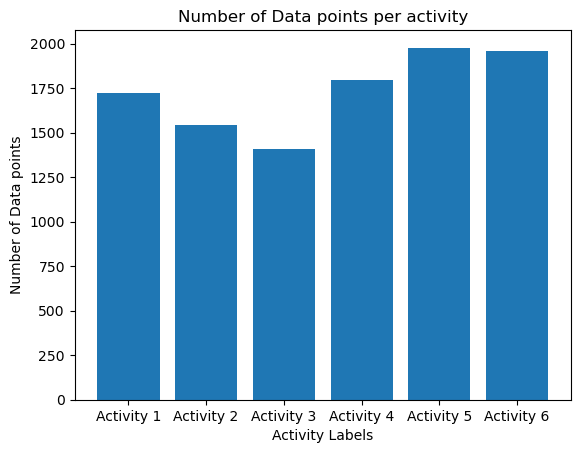

In [97]:
# apply the data_exploration_pipeline to dataset type 1
data_exploration_pipeline(Dataset_type_I,1,False)

Dataset type II has a shape of: 12637 rows and 642 columns



The first 3 rows of Dataset type II :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
0,0.002012,0.000431,0.004441,0.004025,0.013983,0.027372,0.004725,0.019132,0.025280,0.010209,...,104.954731,1.070749,1.431913,2.116867,1.431211,0.152888,1.692169,1.478284,5.0,1.0
1,-0.000713,-0.003098,0.000823,0.004491,0.012449,0.022660,0.004168,0.014039,0.022765,0.009030,...,109.749747,1.652580,1.856253,1.210803,1.753009,0.149532,1.687352,1.477548,5.0,1.0
2,-0.000301,0.004025,-0.004280,0.004866,0.009352,0.016821,0.005255,0.010157,0.020681,0.011261,...,110.445137,1.776612,1.159471,1.763958,2.682216,0.157004,1.696158,1.476770,5.0,1.0





rows 500, 501, 502 of Dataset type II :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
500,-0.002838,0.003938,0.001229,0.007675,0.011710,0.007567,0.008171,0.010390,0.009672,0.014154,...,92.904700,0.595612,0.373307,1.919948,1.408653,1.741841,0.767171,0.832664,6.0,2.0
501,0.000645,-0.000686,0.001023,0.010840,0.014041,0.008008,0.012480,0.022424,0.009438,0.021118,...,102.903039,1.512744,2.908417,1.321577,1.450209,1.744285,0.766016,0.834653,6.0,2.0
502,0.002999,-0.003556,-0.002519,0.010914,0.013154,0.007891,0.012220,0.014542,0.007651,0.021118,...,106.129338,2.696368,0.700894,1.778412,1.796154,1.745504,0.766503,0.834582,6.0,2.0





Description of the 10 first features:


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X
count,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000
mean,-0.000021,-0.000012,0.000025,0.129527,0.091432,0.077082,0.117569,0.082015,0.069997,0.325529
std,0.009201,0.007817,0.007812,0.132270,0.077842,0.066147,0.124176,0.070374,0.059358,0.334534
min,-0.046247,-0.053277,-0.042451,0.001815,0.002371,0.003535,0.001536,0.001921,0.002615,0.003151
25%,-0.003742,-0.003890,-0.003715,0.010734,0.014096,0.013458,0.011465,0.015104,0.014450,0.021017
50%,-0.000032,0.000007,-0.000092,0.070663,0.083293,0.070395,0.049695,0.066805,0.057120,0.165403
75%,0.003711,0.003810,0.003636,0.233780,0.157675,0.128477,0.214532,0.139145,0.116226,0.603124
max,0.045010,0.059873,0.054561,0.661947,0.344200,0.347364,0.754020,0.360647,0.413934,1.226526





Description of the 10 first frequency features:


,f_body_acc_mean()_X,f_body_acc_mean()_Y,f_body_acc_mean()_Z,f_body_acc_std()_X,f_body_acc_std()_Y,f_body_acc_std()_Z,f_body_acc_mad()_X,f_body_acc_mad()_Y,f_body_acc_mad()_Z,f_body_acc_max()_X
count,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000,12637.000000
mean,0.754216,0.578450,0.476064,1.256014,0.857476,0.729452,0.334269,0.268586,0.245777,7.879666
std,0.771683,0.521954,0.432056,1.286780,0.714961,0.618852,0.365928,0.276620,0.263781,8.381218
min,0.015014,0.018181,0.027632,0.013632,0.019648,0.027300,0.006298,0.006759,0.011345,0.051908
25%,0.051858,0.066700,0.068472,0.112203,0.148888,0.140199,0.021935,0.023864,0.032403,0.792914
50%,0.417748,0.472710,0.398896,0.676724,0.808277,0.671380,0.162565,0.156868,0.135418,3.851823
75%,1.389058,1.026513,0.811101,2.241535,1.456542,1.185756,0.584636,0.472082,0.402812,13.706088
max,3.984992,2.311382,2.350887,6.535638,3.602431,3.410963,2.287889,1.855915,2.356723,48.681795





Number of windows per user and per each activity:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
User 1,108,61,61,52,60,56,5,5,6,6,9,6
User 2,65,57,55,52,60,55,5,5,6,7,10,5
User 3,64,69,58,58,69,69,5,3,6,6,7,5
User 4,65,58,56,55,61,58,6,4,7,7,10,5
User 5,62,55,56,50,61,57,7,4,8,7,11,5
User 6,62,60,54,61,63,63,6,4,5,5,9,7
User 7,63,57,57,53,60,56,2,0,7,5,6,5
User 8,55,49,48,52,61,60,4,6,4,7,6,3
User 9,56,56,53,60,53,60,4,2,5,5,7,5
User 10,57,54,49,61,51,65,4,2,5,5,6,2





Statistics of table above:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
count,30.000000,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,63.700000,58.733333,56.200000,66.00000,71.033333,71.333333,5.233333,3.733333,6.300000,6.033333,7.500000,5.433333
std,9.990168,5.906941,5.647093,10.76072,12.141361,11.544019,1.278019,1.574218,1.207734,1.496740,2.487902,1.454679
min,52.000000,48.000000,46.000000,50.00000,51.000000,53.000000,2.000000,0.000000,4.000000,0.000000,0.000000,2.000000
25%,58.000000,56.000000,54.000000,58.25000,61.000000,60.500000,4.250000,2.250000,6.000000,5.250000,6.000000,5.000000
50%,63.000000,58.500000,55.500000,67.00000,69.000000,74.000000,5.000000,4.000000,6.000000,6.000000,7.000000,5.000000
75%,65.000000,61.000000,57.750000,73.75000,80.750000,80.000000,6.000000,5.000000,7.000000,7.000000,9.000000,6.000000
max,108.000000,72.000000,71.000000,90.00000,99.000000,96.000000,8.000000,6.000000,9.000000,9.000000,12.000000,8.000000





_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
Weights,0.151223,0.139432,0.133418,0.156683,0.168632,0.169344,0.012424,0.008863,0.014956,0.014323,0.017805,0.012899


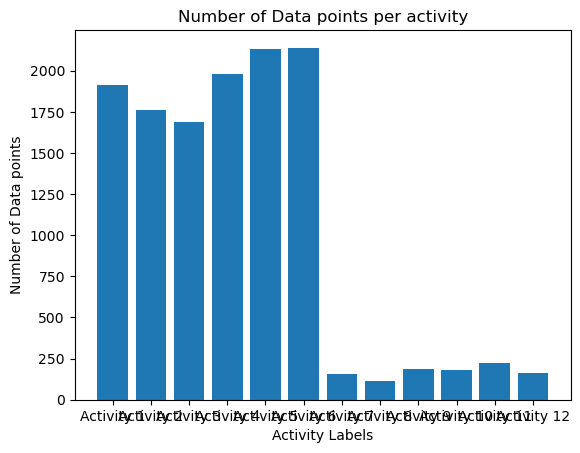

In [8]:
# apply the data exploration pipe line to dataset type II
data_exploration_pipeline(Dataset_type_II,2,False)

# III. Data Preprocessing:

## III.1 Handling Outliers

In [9]:
#####################################################################################
def extract_drop_outliers(Df,threshold,typ):
    #Df: pandas dataframe (Dataset type I or Dataset type II)
    # Threshold: integer : if the number of features detected as ouliers in row exceeds the threshold 
    #                      therow will be considered as "outlier row"
    
    max_range=len(Df["activity_Id"].unique()) # number of unique activities in Df
    
    columns=Df.columns # column names of the dataset
    
    outliers={} # dictionary will contain number of outliers per row . keys are rows' indexes
    for i in range(1,max_range+1):# iterate throw each activity type in the dataset
        
        Df_A=Df[Df['activity_Id']==i] # select rows related to this activity
        
        for column in columns[:-2]:# iterate throw features columns only in Df_A
            
            q1= Df_A[column].describe()['25%'] # the value of the first quartile of a column in Df_A
            
            q3= Df_A[column].describe()['75%'] # the value of the third quartile of a column in Df_A
            
            low_threshold=q1-1.5*(q3-q1) # define low threshold to detect bottom outliers of a column
            high_threshold=q3+1.5*(q3-q1) # define high threshold to detect top outliers of a column
            
            for e in Df_A.index :# iterate throw Df_A indexes
                
                if (Df[column].iloc[e]>high_threshold or Df[column].iloc[e]<low_threshold) :# if value is an outlier
                    
                    if e in outliers.keys(): # if the row index is alread exist in outliers dictionary
                        outliers[e]=outliers[e]+1 # increse the number of ouliers for this row
                    else:# if the row index does not exist yet in  outliers dic keys
                        outliers[e]=1 # add the key with outlier number =1
    
    indexs=np.array(sorted(outliers.keys())) # rows indexes contain outlier values sorted from low to high
    values=np.array([outliers[indexs[i]] for i in range(len(indexs))]) # number of outliers related to each row

    indexs_droped=indexs[values>threshold]# store indexes having number of outliers exceeding the threshold in a list
    
    # Build outliers dataframe using row's indexes
    outliers_data=np.array([list(Df.iloc[indexs_droped[i]]) for i in range(len(indexs_droped))])
    outliers_Df= pd.DataFrame(data=outliers_data,columns= columns)
    
    # generate the clean dataframe by droping outliers from the original dataframe
    clean_Df=Df.drop(indexs_droped,0,)
    
    # adapting the name of the dataset switch the case
    if typ==1:
        dataset_name='Dataset type I'
    if typ==2:
        dataset_name="Dataset type II"
    
    #### report
    print("")
    print("_______________________________ Original Data Frame info...____________________________________")
    print('Number of rows in the original dataframe '+dataset_name+':',len(Df) ) # original dataset lenght
    print("")
    print("")
    visualize_column(Df,'activity_Id') # activity distribution of the original dataset
    print("")
    print("")
    print("________________________________ Outliers info...________________________________________________")
    print("A row is considered as outlier if the number of its outliers exceeds: "+str(threshold)) # threshold info
    print('Number of rows droped :',len(indexs_droped) ) # number of rows considered as outliers
    print("")
    print("")
    data_exploration_pipeline(outliers_Df,typ,True) # Apply the data exploration pipeline to outliers dataframe
    print("")
    print("")
    print ("________________________________ Cleaned+" +dataset_name+" Dataframe info...________________________________________")
    print ('Number of rows in the clean dataframe '+dataset_name+':',len(clean_Df)) # clean dataframe info
    print("")
    print("")
    print("")
    print("")
    data_exploration_pipeline(clean_Df,typ,False)# apply the data exploration pipeline to the clean dataframe
    return clean_Df # return the clean dataset



_______________________________ Original Data Frame info...____________________________________
Number of rows in the original dataframe Dataset type I: 10399


_____ The weights of each activity _____


/var/folders/zz/4j96_gts1qqbmdppm1p3k4mr0000gn/T/ipykernel_44587/2017075652.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  clean_Df=Df.drop(indexs_droped,0,)


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
Weights,0.165401,0.148283,0.135205,0.172805,0.190114,0.188191


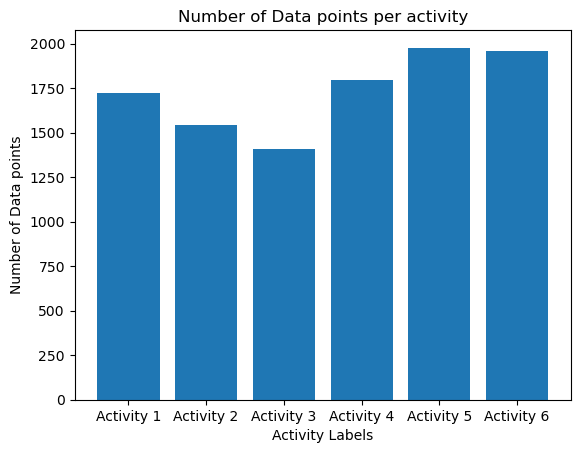



________________________________ Outliers info...________________________________________________
A row is considered as outlier if the number of its outliers exceeds: 100
Number of rows droped : 1166


Outliers of Dataset type I has a shape of: 1166 rows and 642 columns



Number of windows per user and per each activity:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
User 1,0,0,0,3,2,11
User 2,0,1,2,3,7,4
User 3,0,0,0,17,23,10
User 4,0,0,0,15,13,9
User 5,0,0,0,16,24,8
User 6,1,12,14,27,16,17
User 7,8,0,0,14,9,7
User 8,0,12,9,6,7,13
User 9,0,0,0,20,11,27
User 10,0,1,0,8,12,16





Statistics of table above:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.166667,2.566667,2.466667,10.066667,10.966667,10.633333
std,5.925301,5.334878,5.823456,6.689845,7.645072,6.840464
min,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,5.000000,6.000000,6.000000
50%,0.000000,0.000000,0.000000,7.000000,10.500000,8.500000
75%,0.000000,1.000000,0.000000,15.000000,14.500000,14.000000
max,22.000000,20.000000,24.000000,27.000000,34.000000,31.000000





_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
Weights,0.055746,0.066038,0.063465,0.259005,0.282161,0.273585


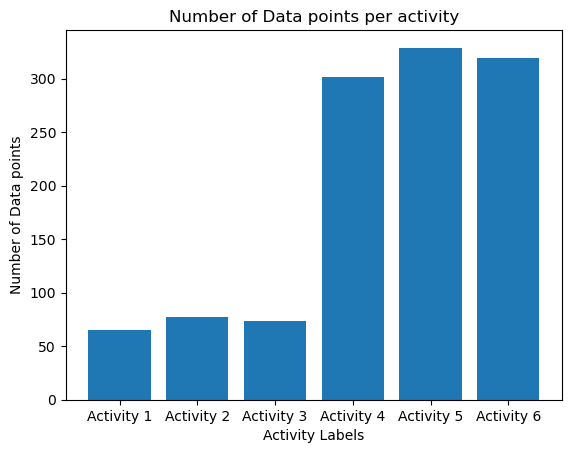



________________________________ Cleaned+Dataset type I Dataframe info...________________________________________
Number of rows in the clean dataframe Dataset type I: 9233




Dataset type I has a shape of: 9233 rows and 642 columns



The first 3 rows of Dataset type I :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
0,0.002012,0.000431,0.004441,0.004025,0.013983,0.027372,0.004725,0.019132,0.025280,0.010209,...,104.954731,1.070749,1.431913,2.116867,1.431211,0.152888,1.692169,1.478284,5.0,1.0
1,-0.000713,-0.003098,0.000823,0.004491,0.012449,0.022660,0.004168,0.014039,0.022765,0.009030,...,109.749747,1.652580,1.856253,1.210803,1.753009,0.149532,1.687352,1.477548,5.0,1.0
2,-0.000301,0.004025,-0.004280,0.004866,0.009352,0.016821,0.005255,0.010157,0.020681,0.011261,...,110.445137,1.776612,1.159471,1.763958,2.682216,0.157004,1.696158,1.476770,5.0,1.0





rows 500, 501, 502 of Dataset type I :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
527,-0.002944,-0.012426,-0.012190,0.005728,0.027819,0.024724,0.005834,0.033920,0.032150,0.009813,...,69.992433,2.003585,1.804211,1.587629,1.637262,0.356367,1.537628,1.216114,4.0,2.0
528,-0.002311,-0.006785,-0.010121,0.008558,0.015155,0.014312,0.008051,0.016058,0.010291,0.034658,...,92.157613,1.685352,2.100664,1.109655,1.597797,0.411527,1.939950,1.397265,5.0,2.0
529,0.000493,0.004908,0.004283,0.007848,0.011278,0.011842,0.008465,0.015903,0.009328,0.012532,...,103.666230,1.679729,0.671063,2.198287,1.904642,0.413992,1.951394,1.415822,5.0,2.0





Description of the 10 first features:


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X
count,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000
mean,0.000106,-0.000229,0.000109,0.134419,0.087805,0.072849,0.126136,0.079964,0.067166,0.330723
std,0.009234,0.006799,0.006837,0.139805,0.081400,0.067965,0.131496,0.072914,0.060304,0.348167
min,-0.047488,-0.038424,-0.047545,0.001815,0.002281,0.003507,0.001536,0.002089,0.002521,0.003151
25%,-0.003194,-0.003549,-0.003240,0.008573,0.011343,0.011020,0.009443,0.012313,0.011954,0.016929
50%,0.000054,-0.000123,-0.000027,0.022836,0.030034,0.027372,0.028085,0.036344,0.032554,0.042353
75%,0.003248,0.003184,0.003262,0.246710,0.161034,0.129855,0.233766,0.143443,0.117874,0.627481
max,0.046679,0.036071,0.045893,0.555511,0.338746,0.317958,0.601142,0.299577,0.282855,1.113230





Description of the 10 first frequency features:


,f_body_acc_mean()_X,f_body_acc_mean()_Y,f_body_acc_mean()_Z,f_body_acc_std()_X,f_body_acc_std()_Y,f_body_acc_std()_Z,f_body_acc_mad()_X,f_body_acc_mad()_Y,f_body_acc_mad()_Z,f_body_acc_max()_X
count,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000
mean,0.774885,0.564345,0.457214,1.308013,0.817656,0.685013,0.339979,0.268215,0.242385,8.370037
std,0.811851,0.549616,0.442992,1.361990,0.742803,0.634053,0.378119,0.288406,0.262074,8.940847
min,0.015014,0.019182,0.028569,0.013632,0.019417,0.025974,0.006711,0.006004,0.011886,0.051908
25%,0.042714,0.054223,0.058634,0.089610,0.119609,0.113962,0.018544,0.020268,0.029038,0.654762
50%,0.096350,0.133185,0.119858,0.248422,0.322917,0.298298,0.043612,0.047309,0.051015,1.944103
75%,1.460796,1.060396,0.839105,2.370136,1.482731,1.189677,0.624989,0.497541,0.430384,14.904714
max,3.099702,2.277406,2.104386,5.491817,3.198097,3.203614,1.795844,1.360118,1.441752,38.437992





Number of windows per user and per each activity:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
User 1,95,53,49,44,53,37
User 2,59,47,45,43,48,45
User 3,58,59,49,34,40,53
User 4,60,52,45,33,43,43
User 5,56,47,47,27,33,43
User 6,56,39,34,29,42,39
User 7,49,51,47,33,45,43
User 8,47,29,29,39,50,42
User 9,52,49,42,33,38,27
User 10,53,46,38,47,34,43





Statistics of table above:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.0000
mean,55.166667,48.833333,44.400000,49.833333,54.933333,54.6000
std,11.228300,9.251592,8.791061,13.696421,14.115126,13.7555
min,31.000000,26.000000,15.000000,27.000000,33.000000,27.0000
25%,51.250000,46.250000,42.000000,39.500000,45.250000,43.0000
50%,56.000000,51.000000,45.500000,48.500000,49.500000,57.0000
75%,59.000000,53.750000,47.750000,58.750000,67.750000,65.7500
max,95.000000,65.000000,62.000000,78.000000,79.000000,82.0000





_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
Weights,0.179248,0.15867,0.144265,0.161919,0.17849,0.177407


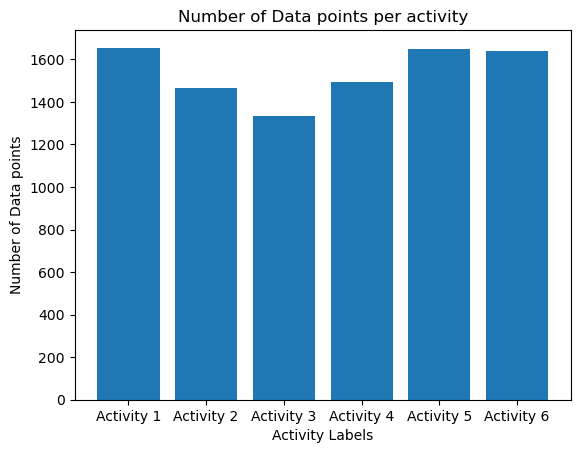

In [10]:
# apply extract drop outliers to dataset type I
clean_Dataset_type_I= extract_drop_outliers(Dataset_type_I,100,1)# store the clean dataframe


_______________________________ Original Data Frame info...____________________________________
Number of rows in the original dataframe Dataset type II: 12637


_____ The weights of each activity _____


/var/folders/zz/4j96_gts1qqbmdppm1p3k4mr0000gn/T/ipykernel_44587/2017075652.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  clean_Df=Df.drop(indexs_droped,0,)


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
Weights,0.151223,0.139432,0.133418,0.156683,0.168632,0.169344,0.012424,0.008863,0.014956,0.014323,0.017805,0.012899


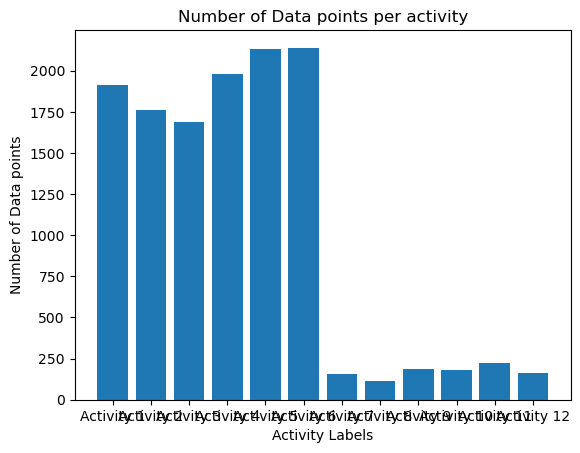



________________________________ Outliers info...________________________________________________
A row is considered as outlier if the number of its outliers exceeds: 100
Number of rows droped : 1475


Outliers ofDataset type II has a shape of: 1475 rows and 642 columns



Number of windows per user and per each activity:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
User 1,0,0,0,8,6,17,0,0,0,0,0,0
User 2,0,3,2,7,13,10,2,0,0,0,0,0
User 3,0,0,0,18,26,12,0,0,0,0,2,0
User 4,0,0,0,17,14,14,0,0,0,2,0,0
User 5,0,0,0,15,22,8,0,0,0,0,0,3
User 6,2,16,21,21,17,19,3,2,0,4,3,3
User 7,5,0,0,11,11,12,0,0,0,0,0,3
User 8,1,14,10,12,9,17,0,2,0,0,2,1
User 9,0,0,0,21,11,28,0,0,0,0,1,3
User 10,0,1,0,14,15,15,2,0,4,4,2,1





Statistics of table above:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.466667,2.866667,3.166667,11.966667,12.633333,13.600000,0.400000,0.333333,0.400000,0.333333,0.466667,0.533333
std,7.001149,5.715878,7.737430,4.582450,5.690181,5.562188,0.894427,0.758098,1.069966,1.061337,0.937102,1.041661
min,0.000000,0.000000,0.000000,6.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,8.250000,8.250000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,11.000000,12.500000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,15.000000,14.750000,17.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000
max,27.000000,19.000000,32.000000,22.000000,26.000000,28.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000





_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
Weights,0.050169,0.058305,0.064407,0.24339,0.256949,0.27661,0.008136,0.00678,0.008136,0.00678,0.009492,0.010847


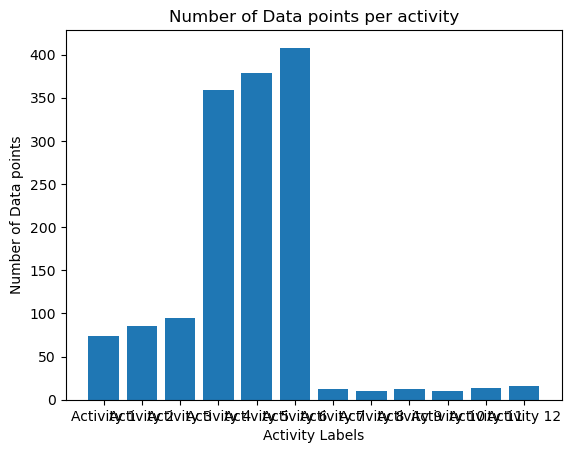



________________________________ Cleaned+Dataset type II Dataframe info...________________________________________
Number of rows in the clean dataframe Dataset type II: 11162




Dataset type II has a shape of: 11162 rows and 642 columns



The first 3 rows of Dataset type II :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
0,0.002012,0.000431,0.004441,0.004025,0.013983,0.027372,0.004725,0.019132,0.025280,0.010209,...,104.954731,1.070749,1.431913,2.116867,1.431211,0.152888,1.692169,1.478284,5.0,1.0
1,-0.000713,-0.003098,0.000823,0.004491,0.012449,0.022660,0.004168,0.014039,0.022765,0.009030,...,109.749747,1.652580,1.856253,1.210803,1.753009,0.149532,1.687352,1.477548,5.0,1.0
2,-0.000301,0.004025,-0.004280,0.004866,0.009352,0.016821,0.005255,0.010157,0.020681,0.011261,...,110.445137,1.776612,1.159471,1.763958,2.682216,0.157004,1.696158,1.476770,5.0,1.0





rows 500, 501, 502 of Dataset type II :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
551,-0.012305,0.000239,-0.007489,0.178805,0.136779,0.103982,0.156816,0.121842,0.136083,0.431281,...,95.271875,2.540275,2.259276,0.335739,1.913493,0.324945,1.895142,1.551758,1.0,2.0
552,-0.009069,0.005967,-0.003001,0.187432,0.135485,0.096906,0.156248,0.114948,0.130979,0.431281,...,99.060916,2.784486,1.514972,0.599218,1.077478,0.324397,1.894571,1.551406,1.0,2.0
553,0.006119,0.010412,0.003517,0.170990,0.140625,0.103101,0.149613,0.103500,0.111266,0.375686,...,95.542622,1.359307,0.373130,0.789207,2.249128,0.316433,1.886737,1.553741,1.0,2.0





Description of the 10 first features:


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,-0.000100,0.000013,-0.000031,0.133528,0.091768,0.076617,0.121742,0.082952,0.070394,0.335502
std,0.009133,0.007369,0.007432,0.132705,0.077968,0.065510,0.123591,0.070053,0.058752,0.337439
min,-0.046247,-0.053277,-0.042451,0.001815,0.002371,0.003535,0.001536,0.001921,0.002615,0.003151
25%,-0.003672,-0.003622,-0.003529,0.009718,0.012898,0.012353,0.010759,0.014022,0.013404,0.019114
50%,-0.000074,0.000021,-0.000116,0.093282,0.101556,0.077919,0.071413,0.082742,0.067476,0.223442
75%,0.003510,0.003596,0.003441,0.237883,0.158614,0.129117,0.218726,0.141180,0.117314,0.615112
max,0.045010,0.041782,0.044077,0.545615,0.344200,0.303396,0.632914,0.360647,0.384583,1.113230





Description of the 10 first frequency features:


,f_body_acc_mean()_X,f_body_acc_mean()_Y,f_body_acc_mean()_Z,f_body_acc_std()_X,f_body_acc_std()_Y,f_body_acc_std()_Z,f_body_acc_mad()_X,f_body_acc_mad()_Y,f_body_acc_mad()_Z,f_body_acc_max()_X
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,0.772696,0.581905,0.472153,1.297549,0.859322,0.725643,0.339665,0.271808,0.243708,8.175407
std,0.771309,0.522189,0.422343,1.292845,0.716430,0.616372,0.362136,0.274672,0.250152,8.443110
min,0.015014,0.018181,0.027632,0.013632,0.019648,0.027300,0.006298,0.006759,0.011345,0.051908
25%,0.047688,0.060626,0.063985,0.102408,0.136141,0.128495,0.020321,0.022092,0.031033,0.745156
50%,0.540020,0.597268,0.464441,0.889930,0.950254,0.726380,0.220190,0.200343,0.157640,4.963227
75%,1.410956,1.033533,0.819169,2.283636,1.466308,1.191119,0.597980,0.480259,0.409944,14.077887
max,3.037541,2.311382,2.012663,5.398025,3.602431,3.043436,2.287889,1.397714,1.670929,38.571898





Number of windows per user and per each activity:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
User 1,108,61,61,44,54,39,5,5,6,6,9,6
User 2,65,54,53,45,47,45,3,5,6,7,10,5
User 3,64,69,58,40,43,57,5,3,6,6,5,5
User 4,65,58,56,38,47,44,6,4,7,5,10,5
User 5,62,55,56,35,39,49,7,4,8,7,11,2
User 6,60,44,33,40,46,44,3,2,5,1,6,4
User 7,58,57,57,42,49,44,2,0,7,5,6,2
User 8,54,35,38,40,52,43,4,4,4,7,4,2
User 9,56,56,53,39,42,32,4,2,5,5,6,2
User 10,57,53,49,47,36,50,2,2,1,1,4,1





Statistics of table above:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,61.233333,55.866667,53.033333,54.033333,58.400000,57.733333,4.833333,3.400000,5.900000,5.700000,7.033333,4.900000
std,12.934006,9.754692,10.697996,12.321787,13.586504,13.266326,1.599210,1.522249,1.709003,1.950243,2.797577,1.881855
min,30.000000,29.000000,15.000000,35.000000,36.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,57.250000,53.000000,50.750000,44.000000,49.250000,45.750000,4.000000,2.000000,5.000000,5.000000,6.000000,4.000000
50%,62.000000,57.000000,55.000000,55.500000,53.500000,58.500000,5.000000,4.000000,6.000000,6.000000,7.000000,5.000000
75%,65.000000,61.000000,56.750000,62.750000,69.500000,67.000000,6.000000,4.750000,7.000000,7.000000,9.000000,6.000000
max,108.000000,72.000000,71.000000,80.000000,85.000000,84.000000,8.000000,6.000000,9.000000,9.000000,12.000000,8.000000





_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
Weights,0.164576,0.150152,0.142537,0.145225,0.156961,0.155169,0.012991,0.009138,0.015857,0.01532,0.018903,0.01317


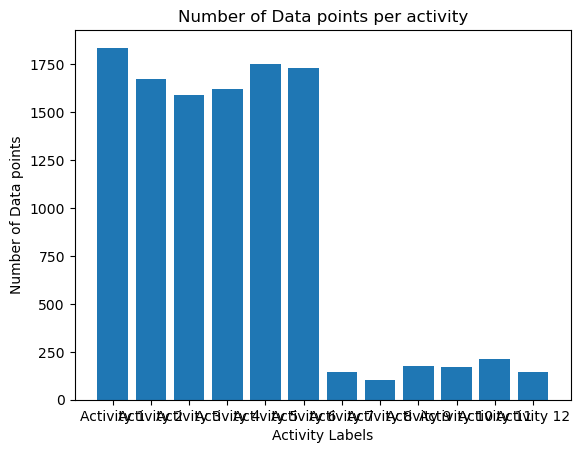

In [11]:
# apply drop extract outliers to dataset type
clean_Dataset_type_II= extract_drop_outliers(Dataset_type_II,100,2)# store the clean dataframe

## III.2 Features Scaling

In [12]:
#################################################################################
def scaling_array(oneD_signal):
    # inputs: 1D numpy array (one column)
    maximum=oneD_signal.max() # maximum of the column
    minimum=oneD_signal.min() # min value of the column
    Difference=float(maximum-minimum) # max-min
    # scaling formula: 2 * (x_i-minimum)/(maximum -minimum)
    # apply the scaling formula to each value in the column
    scaled_signal=np.array([((float(oneD_signal[i])-minimum)/float(Difference))*2 -1 for i in range(len(oneD_signal))])
    
    #return the scaled array
    return scaled_signal

def scaling_DF(data_frame):
    # input : pandas dataframe (clean datasets type I or II)
    columns=data_frame.columns# column names
    # apply the scaling function to each feature columns only
    scaled_array=np.apply_along_axis(scaling_array,0,np.array(data_frame[columns[:-2]]))
    
    # buid the scaled dataset
    scaled_df=pd.DataFrame(data=scaled_array,columns=columns[:-2])
    
    # the user and activity ids columns
    scaled_df['activity_Id']=np.array(data_frame['activity_Id'])
    scaled_df['user_Id']=np.array(data_frame['user_Id'])
    
    return scaled_df # return the scaled dataset

###################################################################################

Dataset type I has a shape of: 9233 rows and 642 columns



The first 3 rows of Dataset type I :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
0,0.051326,0.043149,0.112734,-0.992018,-0.930446,-0.848213,-0.989362,-0.885423,-0.837624,-0.987283,...,0.791006,-0.320689,-0.091183,0.349595,-0.079805,-0.842265,0.180808,-0.059645,5.0,1.0
1,-0.006554,-0.051582,0.035282,-0.990336,-0.939562,-0.878181,-0.991221,-0.919660,-0.855571,-0.989407,...,0.883466,0.053468,0.180498,-0.230454,0.127201,-0.845784,0.177436,-0.060186,5.0,1.0
2,0.002200,0.139646,-0.073936,-0.988981,-0.957971,-0.915318,-0.987595,-0.945763,-0.870437,-0.985389,...,0.896875,0.133229,-0.265611,0.123668,0.724941,-0.837948,0.183600,-0.060759,5.0,1.0





rows 500, 501, 502 of Dataset type I :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
500,-0.053931,-0.302034,-0.243249,-0.985867,-0.848199,-0.865056,-0.985665,-0.786000,-0.788612,-0.987998,...,0.116842,0.279188,0.147179,0.010784,0.052743,-0.628840,0.072625,-0.252448,4.0,2.0
501,-0.040500,-0.150576,-0.198964,-0.975644,-0.923477,-0.931274,-0.978268,-0.906084,-0.944562,-0.943236,...,0.544244,0.074543,0.336980,-0.295207,0.027356,-0.570983,0.354262,-0.119227,5.0,2.0
502,0.019069,0.163345,0.109356,-0.978209,-0.946522,-0.946986,-0.976886,-0.907130,-0.951434,-0.983099,...,0.766160,0.070927,-0.578311,0.401719,0.224743,-0.568398,0.362272,-0.105581,5.0,2.0





Description of the 10 first features:


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X
count,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000
mean,0.010846,0.025428,0.020011,-0.521025,-0.491636,-0.558962,-0.584393,-0.476448,-0.538796,-0.409822
std,0.196114,0.182540,0.146337,0.504987,0.483855,0.432279,0.438608,0.490196,0.430227,0.627284
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.059249,-0.063687,-0.051671,-0.975591,-0.946135,-0.952214,-0.973627,-0.931261,-0.932696,-0.975176
50%,0.009746,0.028277,0.017101,-0.924071,-0.835035,-0.848213,-0.911444,-0.769705,-0.785732,-0.929371
75%,0.077577,0.117079,0.087491,-0.115419,-0.056346,-0.196392,-0.225390,-0.049681,-0.177027,0.124838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000





Description of the 10 first frequency features:


,f_body_acc_mean()_X,f_body_acc_mean()_Y,f_body_acc_mean()_Z,f_body_acc_std()_X,f_body_acc_std()_Y,f_body_acc_std()_Z,f_body_acc_mad()_X,f_body_acc_mad()_Y,f_body_acc_mad()_Z,f_body_acc_max()_X
count,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000
mean,-0.507327,-0.517176,-0.587011,-0.527442,-0.497754,-0.585202,-0.627453,-0.612719,-0.677594,-0.566607
std,0.526375,0.486768,0.426813,0.497241,0.467366,0.399072,0.422685,0.425971,0.366571,0.465838
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.982040,-0.968966,-0.971033,-0.972262,-0.936960,-0.944621,-0.986773,-0.978933,-0.976009,-0.968590
50%,-0.947264,-0.899033,-0.912045,-0.914282,-0.809040,-0.828600,-0.958750,-0.938994,-0.945269,-0.901412
75%,-0.062607,-0.077847,-0.219068,-0.139677,-0.079295,-0.267568,-0.308852,-0.274010,-0.414634,-0.226136
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000





Number of windows per user and per each activity:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
User 1,95,53,49,44,53,37
User 2,59,47,45,43,48,45
User 3,58,59,49,34,40,53
User 4,60,52,45,33,43,43
User 5,56,47,47,27,33,43
User 6,56,39,34,29,42,39
User 7,49,51,47,33,45,43
User 8,47,29,29,39,50,42
User 9,52,49,42,33,38,27
User 10,53,46,38,47,34,43





Statistics of table above:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.0000
mean,55.166667,48.833333,44.400000,49.833333,54.933333,54.6000
std,11.228300,9.251592,8.791061,13.696421,14.115126,13.7555
min,31.000000,26.000000,15.000000,27.000000,33.000000,27.0000
25%,51.250000,46.250000,42.000000,39.500000,45.250000,43.0000
50%,56.000000,51.000000,45.500000,48.500000,49.500000,57.0000
75%,59.000000,53.750000,47.750000,58.750000,67.750000,65.7500
max,95.000000,65.000000,62.000000,78.000000,79.000000,82.0000





_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
Weights,0.179248,0.15867,0.144265,0.161919,0.17849,0.177407


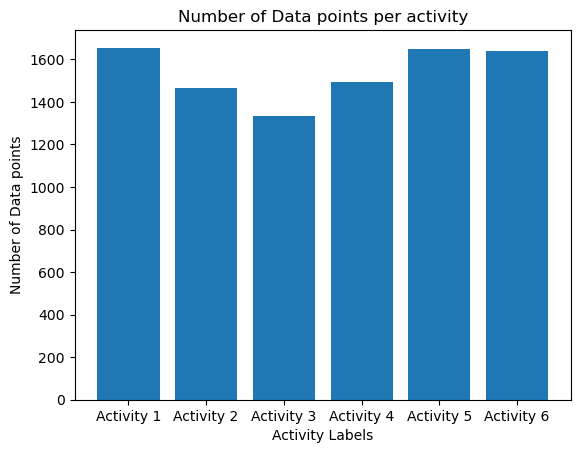

In [13]:
# apply the scaling function to cleaned dataset type I
scaled_type_I=scaling_DF(clean_Dataset_type_I)

# explore the scaled dataset type I
data_exploration_pipeline(scaled_type_I,1,False)

Dataset type II has a shape of: 11162 rows and 642 columns



The first 3 rows of Dataset type II :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
0,0.057656,0.129985,0.083852,-0.991872,-0.932060,-0.841013,-0.989898,-0.904046,-0.881322,-0.987283,...,0.796342,-0.322101,-0.086128,0.353487,-0.087620,-0.844450,0.179862,-0.040856,5.0,1.0
1,-0.002071,0.055747,0.000216,-0.990160,-0.941033,-0.872439,-0.991663,-0.932438,-0.894494,-0.989407,...,0.882150,0.052825,0.185877,-0.226373,0.118652,-0.847921,0.176493,-0.041387,5.0,1.0
2,0.006962,0.205607,-0.117723,-0.988781,-0.959152,-0.911384,-0.988219,-0.954085,-0.905404,-0.985389,...,0.894594,0.132750,-0.260766,0.127633,0.714273,-0.840192,0.182652,-0.041949,5.0,1.0





rows 500, 501, 502 of Dataset type II :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
500,-0.256123,0.125954,-0.191903,-0.349063,-0.213592,-0.330042,-0.508122,-0.331405,-0.301156,-0.228649,...,0.623065,0.624847,0.444219,-0.786394,0.221523,-0.666483,0.321834,0.012201,1.0,2.0
501,-0.185210,0.246477,-0.088161,-0.317336,-0.221163,-0.377236,-0.509923,-0.369845,-0.327881,-0.228649,...,0.690871,0.782214,-0.032887,-0.617773,-0.314362,-0.667049,0.321434,0.011946,1.0,2.0
502,0.147668,0.339981,0.062504,-0.377804,-0.191089,-0.335916,-0.530940,-0.433669,-0.431100,-0.328814,...,0.627910,-0.136157,-0.764817,-0.496185,0.436664,-0.675287,0.315955,0.013633,1.0,2.0





Description of the 10 first features:


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,0.011355,0.121200,-0.019519,-0.515584,-0.476947,-0.512558,-0.619226,-0.548228,-0.645105,-0.401212
std,0.200167,0.155037,0.171783,0.488067,0.456181,0.436934,0.391496,0.390565,0.307630,0.607955
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.066911,0.044710,-0.100364,-0.970934,-0.938405,-0.941182,-0.970784,-0.932536,-0.943506,-0.971241
50%,0.011944,0.121372,-0.021476,-0.663600,-0.419682,-0.503877,-0.778651,-0.549399,-0.660385,-0.603108
75%,0.090482,0.196587,0.060745,-0.131784,-0.085841,-0.162395,-0.312013,-0.223594,-0.399430,0.102554
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000





Description of the 10 first frequency features:


,f_body_acc_mean()_X,f_body_acc_mean()_Y,f_body_acc_mean()_Z,f_body_acc_std()_X,f_body_acc_std()_Y,f_body_acc_std()_Z,f_body_acc_mad()_X,f_body_acc_mad()_Y,f_body_acc_mad()_Z,f_body_acc_max()_X
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,-0.498643,-0.508352,-0.552127,-0.523097,-0.531273,-0.536929,-0.707776,-0.618896,-0.719974,-0.578219
std,0.510374,0.455424,0.425528,0.480220,0.399930,0.408716,0.317442,0.394940,0.301464,0.438375
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.978379,-0.962982,-0.963372,-0.967025,-0.934971,-0.932897,-0.987707,-0.977952,-0.976274,-0.964006
50%,-0.652604,-0.494953,-0.559897,-0.674504,-0.480512,-0.536440,-0.812506,-0.721652,-0.823696,-0.744999
75%,-0.076308,-0.114467,-0.202494,-0.156821,-0.192438,-0.228271,-0.481343,-0.319173,-0.519640,-0.271756
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000





Number of windows per user and per each activity:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
User 1,108,61,61,44,54,39,5,5,6,6,9,6
User 2,65,54,53,45,47,45,3,5,6,7,10,5
User 3,64,69,58,40,43,57,5,3,6,6,5,5
User 4,65,58,56,38,47,44,6,4,7,5,10,5
User 5,62,55,56,35,39,49,7,4,8,7,11,2
User 6,60,44,33,40,46,44,3,2,5,1,6,4
User 7,58,57,57,42,49,44,2,0,7,5,6,2
User 8,54,35,38,40,52,43,4,4,4,7,4,2
User 9,56,56,53,39,42,32,4,2,5,5,6,2
User 10,57,53,49,47,36,50,2,2,1,1,4,1





Statistics of table above:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,61.233333,55.866667,53.033333,54.033333,58.400000,57.733333,4.833333,3.400000,5.900000,5.700000,7.033333,4.900000
std,12.934006,9.754692,10.697996,12.321787,13.586504,13.266326,1.599210,1.522249,1.709003,1.950243,2.797577,1.881855
min,30.000000,29.000000,15.000000,35.000000,36.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,57.250000,53.000000,50.750000,44.000000,49.250000,45.750000,4.000000,2.000000,5.000000,5.000000,6.000000,4.000000
50%,62.000000,57.000000,55.000000,55.500000,53.500000,58.500000,5.000000,4.000000,6.000000,6.000000,7.000000,5.000000
75%,65.000000,61.000000,56.750000,62.750000,69.500000,67.000000,6.000000,4.750000,7.000000,7.000000,9.000000,6.000000
max,108.000000,72.000000,71.000000,80.000000,85.000000,84.000000,8.000000,6.000000,9.000000,9.000000,12.000000,8.000000





_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
Weights,0.164576,0.150152,0.142537,0.145225,0.156961,0.155169,0.012991,0.009138,0.015857,0.01532,0.018903,0.01317


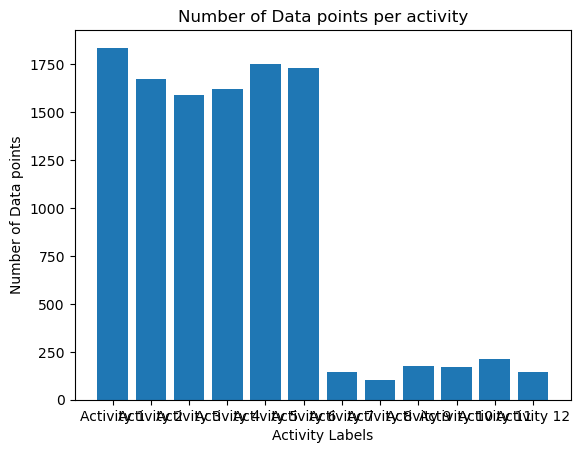

In [14]:
# apply the scaling function to cleaned dataset type II
scaled_type_II=scaling_DF(clean_Dataset_type_II)

# explore the scaled dataset type II
data_exploration_pipeline(scaled_type_II,2,False)

# VI Dataset type III:

## VI.1. Dataset type III generation

In [15]:
act_labels=list(scaled_type_II['activity_Id']) # extract activity labels from scaled type II (ids from 1 to 12)

for i in range(len(act_labels)):# iterate throw each activity label
    
    if act_labels[i]>6: # if activity label belongs to postural transitions ids from 7 to 12
        act_labels[i]=7 # the target will be replaced by the id=7 (postural transition)

# build dataset type III by replacing the activity id column by the new column create above
scaled_type_III=pd.DataFrame(data=np.array(scaled_type_II),columns=scaled_type_II.columns)
scaled_type_III['activity_Id']=np.array(act_labels)

## VI.2. Dataset type III exploration

Dataset type III has a shape of: 11162 rows and 642 columns



The first 3 rows of Dataset type III :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
0,0.057656,0.129985,0.083852,-0.991872,-0.932060,-0.841013,-0.989898,-0.904046,-0.881322,-0.987283,...,0.796342,-0.322101,-0.086128,0.353487,-0.087620,-0.844450,0.179862,-0.040856,5.0,1.0
1,-0.002071,0.055747,0.000216,-0.990160,-0.941033,-0.872439,-0.991663,-0.932438,-0.894494,-0.989407,...,0.882150,0.052825,0.185877,-0.226373,0.118652,-0.847921,0.176493,-0.041387,5.0,1.0
2,0.006962,0.205607,-0.117723,-0.988781,-0.959152,-0.911384,-0.988219,-0.954085,-0.905404,-0.985389,...,0.894594,0.132750,-0.260766,0.127633,0.714273,-0.840192,0.182652,-0.041949,5.0,1.0





rows 500, 501, 502 of Dataset type III :


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_gyro_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4(),angle5(),angle6(),activity_Id,user_Id
500,-0.256123,0.125954,-0.191903,-0.349063,-0.213592,-0.330042,-0.508122,-0.331405,-0.301156,-0.228649,...,0.623065,0.624847,0.444219,-0.786394,0.221523,-0.666483,0.321834,0.012201,1.0,2.0
501,-0.185210,0.246477,-0.088161,-0.317336,-0.221163,-0.377236,-0.509923,-0.369845,-0.327881,-0.228649,...,0.690871,0.782214,-0.032887,-0.617773,-0.314362,-0.667049,0.321434,0.011946,1.0,2.0
502,0.147668,0.339981,0.062504,-0.377804,-0.191089,-0.335916,-0.530940,-0.433669,-0.431100,-0.328814,...,0.627910,-0.136157,-0.764817,-0.496185,0.436664,-0.675287,0.315955,0.013633,1.0,2.0





Description of the 10 first features:


,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,0.011355,0.121200,-0.019519,-0.515584,-0.476947,-0.512558,-0.619226,-0.548228,-0.645105,-0.401212
std,0.200167,0.155037,0.171783,0.488067,0.456181,0.436934,0.391496,0.390565,0.307630,0.607955
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.066911,0.044710,-0.100364,-0.970934,-0.938405,-0.941182,-0.970784,-0.932536,-0.943506,-0.971241
50%,0.011944,0.121372,-0.021476,-0.663600,-0.419682,-0.503877,-0.778651,-0.549399,-0.660385,-0.603108
75%,0.090482,0.196587,0.060745,-0.131784,-0.085841,-0.162395,-0.312013,-0.223594,-0.399430,0.102554
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000





Description of the 10 first frequency features:


,f_body_acc_mean()_X,f_body_acc_mean()_Y,f_body_acc_mean()_Z,f_body_acc_std()_X,f_body_acc_std()_Y,f_body_acc_std()_Z,f_body_acc_mad()_X,f_body_acc_mad()_Y,f_body_acc_mad()_Z,f_body_acc_max()_X
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,-0.498643,-0.508352,-0.552127,-0.523097,-0.531273,-0.536929,-0.707776,-0.618896,-0.719974,-0.578219
std,0.510374,0.455424,0.425528,0.480220,0.399930,0.408716,0.317442,0.394940,0.301464,0.438375
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.978379,-0.962982,-0.963372,-0.967025,-0.934971,-0.932897,-0.987707,-0.977952,-0.976274,-0.964006
50%,-0.652604,-0.494953,-0.559897,-0.674504,-0.480512,-0.536440,-0.812506,-0.721652,-0.823696,-0.744999
75%,-0.076308,-0.114467,-0.202494,-0.156821,-0.192438,-0.228271,-0.481343,-0.319173,-0.519640,-0.271756
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000





Number of windows per user and per each activity:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,P_Transitions
User 1,108,61,61,44,54,39,37
User 2,65,54,53,45,47,45,36
User 3,64,69,58,40,43,57,30
User 4,65,58,56,38,47,44,37
User 5,62,55,56,35,39,49,39
User 6,60,44,33,40,46,44,21
User 7,58,57,57,42,49,44,22
User 8,54,35,38,40,52,43,25
User 9,56,56,53,39,42,32,24
User 10,57,53,49,47,36,50,11





Statistics of table above:


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,P_Transitions
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,61.233333,55.866667,53.033333,54.033333,58.400000,57.733333,31.766667
std,12.934006,9.754692,10.697996,12.321787,13.586504,13.266326,7.824292
min,30.000000,29.000000,15.000000,35.000000,36.000000,32.000000,11.000000
25%,57.250000,53.000000,50.750000,44.000000,49.250000,45.750000,26.000000
50%,62.000000,57.000000,55.000000,55.500000,53.500000,58.500000,33.000000
75%,65.000000,61.000000,56.750000,62.750000,69.500000,67.000000,37.000000
max,108.000000,72.000000,71.000000,80.000000,85.000000,84.000000,42.000000





_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7
Weights,0.164576,0.150152,0.142537,0.145225,0.156961,0.155169,0.085379


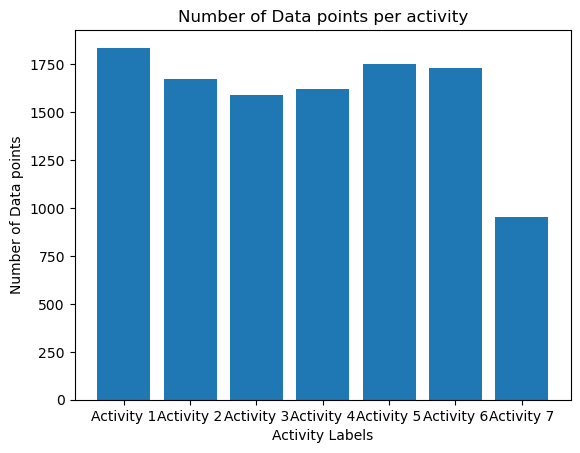

In [16]:
# apply the data exploration pipeline to scaled dataset type III
data_exploration_pipeline(scaled_type_III,3,False)

# V. Train-Test Datasets

## V.1. Train-Test Datasets creation

### Unique Users Ids used for training and testing

In [17]:
# volunteersids used for training
train_users =[1,3,5,6,7,8,10,11,14,15,27,17,21,29,30,16,19,20,22,23,25,]

# volunteers ids used for testing
test_users = [2,4,9,12,13,26,18,28,24,]

### Creating train and test datasets

In [18]:
def create_training_testing_data(scaled_Df,train_users,test_users,typ):
    # inputs:
    #        scaled_DF : pandas dataframe already scaled
    #       train_users: list of integers contains train user ids 
    #       train_users: list of integers contains test user ids 
    #       typ        : integer from 1 to 3 (depending on the dataset type)
    
    # select rows related to train users ids store them in numpy array
    array_train =np.array([np.array(scaled_Df.iloc[i]) 
                           for i in range(len(scaled_Df)) if int(scaled_Df['user_Id'].iloc[i]) in train_users])
    # select rows related to test users ids store them in numpy array
    array_test  =np.array([np.array(scaled_Df.iloc[i]) 
                           for i in range(len(scaled_Df)) if int(scaled_Df['user_Id'].iloc[i]) in test_users])
    
    # columns names
    columns=scaled_Df.columns
    
    # build train and test dataframes from numpy arrays above
    Df_train= pd.DataFrame(data= array_train,columns=columns)
    Df_test = pd.DataFrame(data= array_test,columns=columns)
    
    
    # train features dataframe
    Df_train_features= Df_train[columns[:-2]]
    # train labels dataframe
    Df_train_labels  = Df_train[columns[-2:-1]]
    # train user id labels dataframe
    Df_train_users   = Df_train[columns[-1]]
    
    # test features dataframe
    Df_test_features= Df_test[columns[:-2]]
    # test labels dataframe
    Df_test_labels  = Df_test[columns[-2:-1]]
    # test user id labels dataframe
    Df_test_users   = Df_test[columns[-1]]
    
    # 2D numpy array : train features
    X_train =np.array(Df_train_features)
    
    # 2D numpy array : test features
    X_test  =np.array(Df_test_features)
    
    # 1D numpy array : train labels
    y_train= np.array(Df_train_labels['activity_Id'])
    
    # 1D numpy array : test labels
    y_test = np.array(Df_test_labels ['activity_Id'])
    
    # adapting the dataset name switch the case
    if typ==1:
           Dataset_name="Dataset type I"
    if typ==2:
           Dataset_name="Dataset type II"
    if typ==3:
           Dataset_name="Dataset type III"
    
    print("")
    print("______________________________"+Dataset_name+" Train features & labels info:______________________________________")
    print("")
    visualize_column(Df_train,'activity_Id')# visualize activity distribution of train dataframe
    print("")
    print("______________________________Test features & labels info:______________________________________")
    print("")
    visualize_column(Df_test,'activity_Id') # visualize the activity distribution of the test dataframe
    
    return  [X_train, X_test, y_train, y_test] # return train and test numpy arrays

In [19]:
# dictionary will contain train and test files of each dataframe type
train_test_files_dic={}


______________________________Dataset type I Train features & labels info:______________________________________

_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
Weights,0.179491,0.154206,0.141096,0.164351,0.180272,0.180584


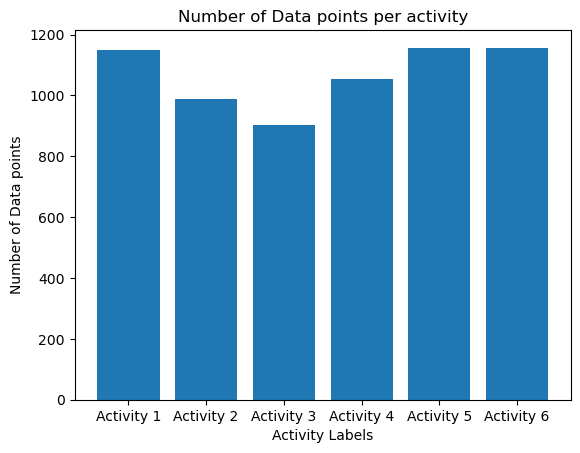


______________________________Test features & labels info:______________________________________

_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6
Weights,0.178698,0.16879,0.151451,0.156405,0.174452,0.170205


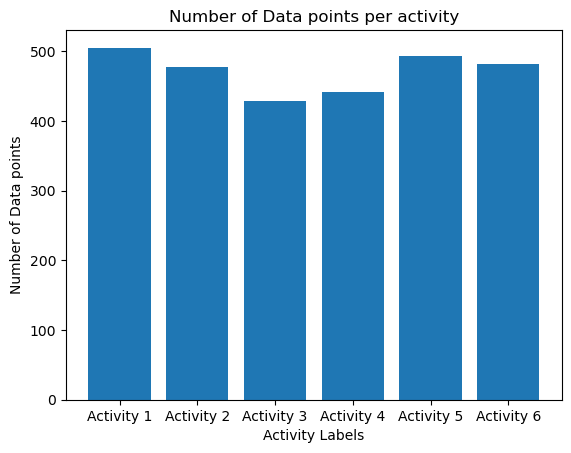

In [20]:
# apply create_training_testing_data to scaled dataset type I
[X_1_train, X_1_test, y_1_train, y_1_test] = create_training_testing_data(scaled_type_I,train_users,test_users,1)

In [21]:
# store train test files type I in the dictionary 
train_test_files_dic[1]=[X_1_train, X_1_test, y_1_train, y_1_test]


______________________________Dataset type II Train features & labels info:______________________________________

_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
Weights,0.164495,0.146433,0.138821,0.147981,0.159334,0.158818,0.012385,0.008902,0.01574,0.015998,0.018836,0.012256


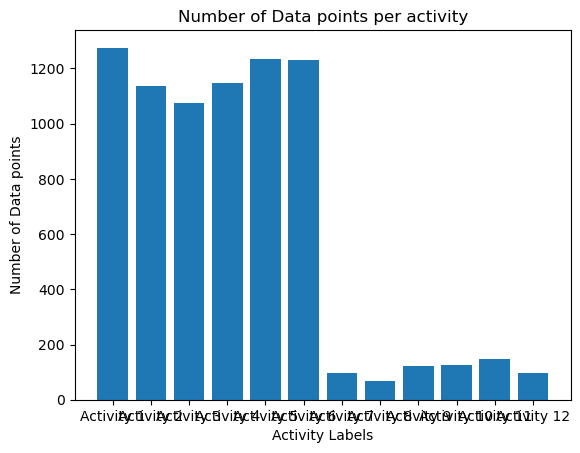


______________________________Test features & labels info:______________________________________

_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,Activity 10,Activity 11,Activity 12
Weights,0.164761,0.158605,0.150982,0.138962,0.151568,0.146878,0.014365,0.009675,0.016124,0.013779,0.019056,0.015245


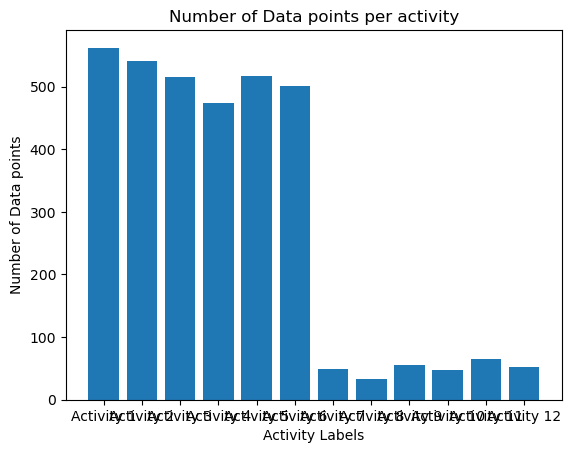

In [22]:
# apply create_training_testing_data to scaled dataset type II
[X_2_train, X_2_test, y_2_train, y_2_test] = create_training_testing_data(scaled_type_II,train_users,test_users,2)

In [23]:
# store train test files type II in the dictionary 
train_test_files_dic[2]= [X_2_train, X_2_test, y_2_train, y_2_test]


______________________________Dataset type III Train features & labels info:______________________________________

_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7
Weights,0.164495,0.146433,0.138821,0.147981,0.159334,0.158818,0.084118


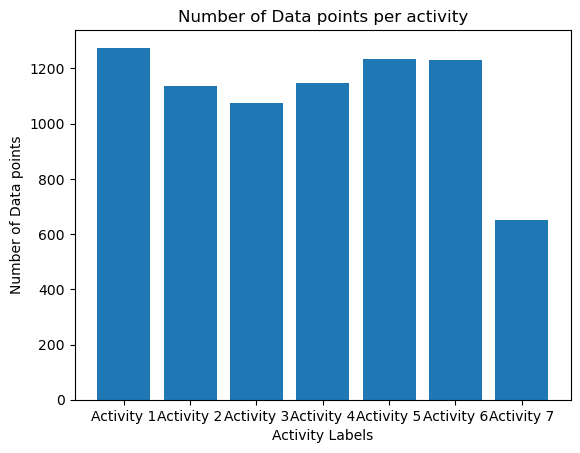


______________________________Test features & labels info:______________________________________

_____ The weights of each activity _____


,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7
Weights,0.164761,0.158605,0.150982,0.138962,0.151568,0.146878,0.088244


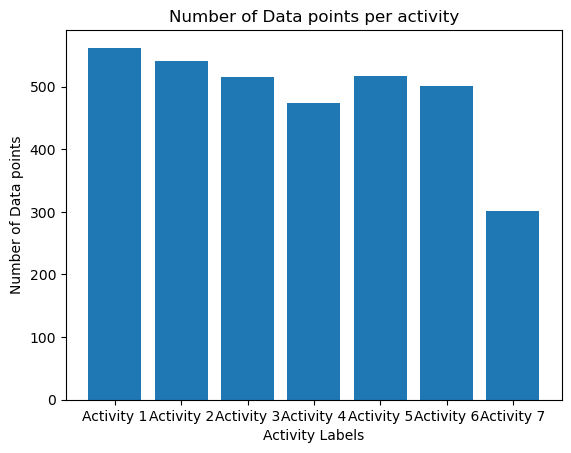

In [24]:
# apply create_training_testing_data to scaled dataset type II
[X_3_train, X_3_test, y_3_train, y_3_test] = create_training_testing_data(scaled_type_III,train_users,test_users,3)

In [25]:
# store train test files type III in the dictionary 
train_test_files_dic[3]=[X_3_train, X_3_test, y_3_train, y_3_test]

# VI. Train-Test PipeLine

In [26]:
from sklearn.naive_bayes import GaussianNB as NB # import gaussian naive bayes classifier
from sklearn.tree import DecisionTreeClassifier as DTC # import decision tree classifier
from sklearn.linear_model import LogisticRegression as LR # import logistic regression classifier

from sklearn.metrics import accuracy_score as accuracy # import accuracy score
from sklearn.metrics import confusion_matrix as cm # import confusion matrix

# intialize models
Benchmark_model =NB()
Clf1=DTC(random_state=337)
Clf2=LR(random_state=337)

In [27]:
# Define the adpted confusion matrix
def full_confusion_matrix(Df): 
    # input: 
    #   Df : pandas dataframe, the contingency table resulted from the confusion matrix defined earlier as cm
    
    columns=Df.columns # activity names
    # add new columns containing detailed scores
    new_columns=list(columns)+['data points number','precision %','sensitivity %','specificity %']
    
    # create the index from the same old columns add an other row called total
    new_index=list(columns)+['Total']
    
    # intialize the confustion matrix dataframe
    new_Df=pd.DataFrame(data=None,columns=new_columns, index= new_index)
    # intilize values
    total_TP=0 # sum of true positives
    total_FN=0 # sum of false negatives
    total_data_points_number=0 # total number of datapoints
    
    for column in columns:
        
        TP=Df.loc[column][column] # extract true postives from the contingency table
        FN=Df.loc[column].sum()-TP # calculate FN(false negatives)
        FP=Df[column].sum()-TP # calculate FP(false positives)
        TN=(Df.sum()).sum()-TP-FN-FP # calculate TN(true negatives)
        class_data_points=TP+FN  # number of datapoints per activity
        # precision score in %
        precision= TP/float(TP+FP) * 100
        # Recall or sensitivity in %
        sensitivity= TP/float(TP+FN) *100
        # sepecificity score in %
        specificity=TN/float(TN+FP) * 100
        
        new_row =list(Df.loc[column])+[class_data_points,precision,sensitivity,specificity]# contenate new scores in one row
        new_Df.loc[column]=new_row # append the row to the dataframe
        
        # update intialized values
        total_data_points_number= total_data_points_number+class_data_points 
        total_TP=total_TP+TP
        total_FN=total_FN+FN
    
    # after iterting throw all activity types
    # the general accuracy of the model is:
    total_accuracy= total_TP/float(total_TP+total_FN) * 100
    
    # add total values to the dataframe
    new_Df.loc['Total'] [['data points number','precision %','sensitivity %','specificity %']]=['data points number='+str(total_data_points_number),'','','accuracy= '+str(total_accuracy)[0:6]+'%']
    new_Df.loc['Total'][columns]=['' for i in range(len(columns))]
    
    return new_Df # return the adapted confusion matrix
        

In [28]:
def train_predict(classifier, sample_size, X_train, X_test, y_train,  y_test,typ): 
    
    # inputs:
    #   classifier: the learning algorithm to be trained and predicted on
    #   sample_size: the size of samples (number) to be drawn from training set
    #   X_train: features training set
    #   y_train: Activity_number_ID training set
    #   X_test: features testing set
    #   y_test: Activity_number_ID testing set
    
    # Empty dictionary will include all dataframes and info related to training and testing.
    results = {}
    
    # Fitting the classifier to the training data using slicing with 'sample_size'
    start= timer() # Get start time
    classifier = classifier.fit(X_train[0:sample_size,:],y_train[0:sample_size])# fiting the classfier
    end = timer() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 3000 training samples(X_train) using .predict()
    start = timer() # Get start time
    predictions_test = classifier.predict(X_test) # predict
    predictions_train =classifier.predict(X_train[:3000,:])
    end = timer() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] =end-start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy(y_train[:3000],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy(y_test,predictions_test)
    
    # Adapting the confusion matrix shape to the type of data used
    if typ==1:
        confusion_matrix=cm(y_test, predictions_test, labels=[1,2,3,4,5,6], sample_weight=None) # 
        columns=['WK','WU','WD','SI','ST','LD']
        index=['WK','WU','WD','SI','ST','LD']
    if typ==2:
        confusion_matrix=cm(y_test, predictions_test, labels=[1,2,3,4,5,6,7,8,9,10,11,12], sample_weight=None)
        columns=['WK','WU','WD','SI','ST','LD','St-Si','Si-St','Si-Li','Li-Si','St-Li','Li-St']
        index=  ['WK','WU','WD','SI','ST','LD','St-Si','Si-St','Si-Li','Li-Si','St-Li','Li-St'] 
    if typ==3:   
        confusion_matrix=cm(y_test, predictions_test, labels=[1,2,3,4,5,6,7], sample_weight=None)
        columns=['WK','WU','WD','SI','ST','LD','PT']
        index=['WK','WU','WD','SI','ST','LD','PT']
    
    if sample_size==len(X_train):# if 100% of training is achieved
        # apply the confusion matrix function to the last contingency table generated
        confusion_matrix_df=(pd.DataFrame(data=confusion_matrix,columns=columns,index=index)).pipe(full_confusion_matrix)
    else:# if not
        # create a dataframe from the contingency table
        confusion_matrix_df=pd.DataFrame(data=confusion_matrix,columns=columns,index=index)
        
    # Return the results
    return (results,confusion_matrix_df)

In [29]:
def train_test_report(classifier,dataset_type):
    # Inputs:
    #  classifier: model will be trained tested and evaluated on all sample sizes
    #  Dataset_type: "All"  or integers 1,2,3 
    # if "All" the classifier will be trained, tested and evaluated on all datasets
    # if integer 1, 2 or 3: the classifier the classifier will be trained, tested and evaluated on one dataset(I,II or III)
    
    if dataset_type!='All': # dataset type equal to 1 ,2 or 3
        # extract train and test files related to dataset type
        new_dic={dataset_type:train_test_files_dic[dataset_type]}
    
    else:# the model will be trained , tested and evaluted on all datasets
        new_dic=train_test_files_dic # import all train and test files
    
    for key in sorted(new_dic.keys()):# iterating throw dataset types
        clf=classifier # reintialize the classifier
        # adapt the dataset name switch the case
        if key==1:
            Dataset_name='Dataset type I'
        if key==2:
            Dataset_name='Dataset type II'
        if key==3:
            Dataset_name='Dataset type III'
        
        files = new_dic[key] # copy train and test files related to the dataset type
        # create a temporal dictionary where train, test and evaluation results will be stored
        results = {}
        print("_____________________"+Dataset_name+" Training and Testing______________________")
        print("")
        
        # copy train and test files
        X_train, X_test, y_train, y_test,= files[0], files[1], files[2], files[3]
        # extract the name of the classifier
        clf_name = clf.__class__.__name__
        
        # training started
        print("{} started training....".format(clf_name) )   
        
        results[clf_name] = {}
        # generate sample sizes
        samples_10 = int(len(X_train)/10) # 10%
        samples_50 = int(len(X_train)/2) # 50%
        samples_100 = int(len(X_train)) # 100%
        
        
        for i, samples in enumerate([samples_10, samples_50, samples_100]): # iterate throw each sample size
            print("...")
            if samples==len(X_train):# when 100% of training will be achieved
                # store results related to the classier and sample size in results dictionary
                # store the full confusion matrix
                results[clf_name][i],confusion_matrix = train_predict(clf, samples, X_train, X_test, y_train, y_test,key)
            else:# if not
                # store results related to the classier and sample size in results dictionary
                results[clf_name][i]= train_predict(clf, samples, X_train,X_test, y_train,  y_test,key)[0]

        print( "Success: {} Finished Training and Testing.".format(clf_name))
        print("")
        print ("________"+clf_name+" results:__________")
        print("")
        print("")
        print("Accuracy and duration per training size")
        # display train and test results
        display(pd.DataFrame(results[clf_name]).rename(columns={0:'10% of train', 1:'50% of train', 2:'100% of train'}))
        print("")
        print("Confusion Matrix Sensitivity and Recall when 100% of train is achieved")
        # display the full confusion matrix results
        display(confusion_matrix)
        print("____________________________________________________________________")
        print("")
        print("")

# VII. Benchmark Model

In [30]:
# training, testing and evaluating the benchmark model on all datasets
train_test_report(Benchmark_model,'All')

_____________________Dataset type I Training and Testing______________________

GaussianNB started training....
...
...
...
Success: GaussianNB Finished Training and Testing.

________GaussianNB results:__________


Accuracy and duration per training size


,10% of train,50% of train,100% of train
train_time,0.003140,0.008296,0.017107
pred_time,0.058882,0.052091,0.052881
acc_train,0.703667,0.758667,0.755000
acc_test,0.700283,0.722930,0.720807



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,data points number,precision %,sensitivity %,specificity %
WK,267,222,16,0,0,0,505,80.664653,52.871287,97.242568
WU,12,461,4,0,0,0,477,58.060453,96.645702,85.823755
WD,52,107,269,0,0,0,428,93.079585,62.850467,99.165972
SI,0,0,0,365,77,0,442,55.30303,82.579186,87.625839
ST,0,4,0,295,194,0,493,71.586716,39.350913,96.699529
LD,0,0,0,0,0,481,481,100.0,100.0,100.0
Total,,,,,,,data points number=2826,,,accuracy= 72.080%


____________________________________________________________________


_____________________Dataset type II Training and Testing______________________

GaussianNB started training....
...
...
...
Success: GaussianNB Finished Training and Testing.

________GaussianNB results:__________


Accuracy and duration per training size


,10% of train,50% of train,100% of train
train_time,0.002689,0.009839,0.018887
pred_time,0.117408,0.119274,0.113423
acc_train,0.655667,0.717667,0.707000
acc_test,0.654060,0.649077,0.654647



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,St-Si,Si-St,Si-Li,Li-Si,St-Li,Li-St,data points number,precision %,sensitivity %,specificity %
WK,305,225,14,0,0,0,1,0,0,0,16,1,562,78.205128,54.270463,97.016497
WU,13,425,0,0,0,0,11,2,6,0,81,3,541,55.26658,78.558226,88.013937
WD,72,118,309,0,0,0,1,0,1,0,14,0,515,95.665635,60.0,99.516575
SI,0,0,0,412,60,2,0,0,0,0,0,0,474,54.64191,86.919831,88.355465
ST,0,0,0,342,160,0,0,13,0,2,0,0,517,72.727273,30.947776,97.926745
LD,0,0,0,0,0,493,0,0,0,8,0,0,501,99.59596,98.403194,99.931271
St-Si,0,0,0,0,0,0,17,23,1,2,5,1,49,50.0,34.693878,99.494349
Si-St,0,0,0,0,0,0,2,31,0,0,0,0,33,38.75,93.939394,98.549438
Si-Li,0,0,0,0,0,0,0,4,6,23,21,1,55,15.384615,10.909091,99.016687
Li-Si,0,0,0,0,0,0,0,6,4,33,2,2,47,32.352941,70.212766,97.94887


____________________________________________________________________


_____________________Dataset type III Training and Testing______________________

GaussianNB started training....
...
...
...
Success: GaussianNB Finished Training and Testing.

________GaussianNB results:__________


Accuracy and duration per training size


,10% of train,50% of train,100% of train
train_time,0.002692,0.009167,0.018216
pred_time,0.070639,0.066669,0.067198
acc_train,0.697000,0.758000,0.752667
acc_test,0.703313,0.706831,0.712108



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,PT,data points number,precision %,sensitivity %,specificity %
WK,305,230,15,0,0,0,12,562,78.205128,54.270463,97.016497
WU,13,447,0,0,0,0,81,541,55.597015,82.624769,87.560976
WD,72,125,309,0,0,0,9,515,95.076923,60.0,99.447514
SI,0,0,0,412,60,2,0,474,54.64191,86.919831,88.355465
ST,0,0,0,342,165,0,10,517,73.333333,31.914894,97.926745
LD,0,0,0,0,0,493,8,501,99.59596,98.403194,99.931271
PT,0,2,1,0,0,0,298,301,71.291866,99.003322,96.141479
Total,,,,,,,,data points number=3411,,,accuracy= 71.210%


____________________________________________________________________




# VIII. Elected Models

- Decision Tree Classifier

In [31]:
# training, testing and evaluating Decision tree classifier on all datasets
train_test_report(Clf1,'All')

_____________________Dataset type I Training and Testing______________________

DecisionTreeClassifier started training....
...
...
...
Success: DecisionTreeClassifier Finished Training and Testing.

________DecisionTreeClassifier results:__________


Accuracy and duration per training size


,10% of train,50% of train,100% of train
train_time,0.090829,0.972050,3.237471
pred_time,0.002684,0.002452,0.003530
acc_train,0.722333,1.000000,1.000000
acc_test,0.739915,0.820594,0.876504



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,data points number,precision %,sensitivity %,specificity %
WK,445,9,51,0,0,0,505,87.084149,88.118812,97.156398
WU,38,380,59,0,0,0,477,87.962963,79.66457,97.786292
WD,28,42,358,0,0,0,428,76.495726,83.64486,95.412844
SI,0,1,0,359,82,0,442,90.201005,81.221719,98.364094
ST,0,0,0,39,454,0,493,84.701493,92.089249,96.485212
LD,0,0,0,0,0,481,481,100.0,100.0,100.0
Total,,,,,,,data points number=2826,,,accuracy= 87.650%


____________________________________________________________________


_____________________Dataset type II Training and Testing______________________

DecisionTreeClassifier started training....
...
...
...
Success: DecisionTreeClassifier Finished Training and Testing.

________DecisionTreeClassifier results:__________


Accuracy and duration per training size


,10% of train,50% of train,100% of train
train_time,0.139370,1.614566,4.541611
pred_time,0.008451,0.003019,0.003190
acc_train,0.762000,1.000000,1.000000
acc_test,0.691000,0.781589,0.826737



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,St-Si,Si-St,Si-Li,Li-Si,St-Li,Li-St,data points number,precision %,sensitivity %,specificity %
WK,525,9,20,0,0,0,6,2,0,0,0,0,562,85.784314,93.41637,96.946297
WU,41,443,52,0,0,0,3,0,0,0,2,0,541,85.356455,81.885397,97.351916
WD,45,65,405,0,0,0,0,0,0,0,0,0,515,84.728033,78.640777,97.479282
SI,0,0,0,388,86,0,0,0,0,0,0,0,474,85.651214,81.85654,97.786857
ST,0,0,0,65,450,0,0,0,0,2,0,0,517,83.955224,87.040619,97.028334
LD,0,0,0,0,0,499,0,0,0,1,0,1,501,100.0,99.600798,100.0
St-Si,1,0,0,0,0,0,20,12,1,2,7,6,49,43.478261,40.816327,99.226651
Si-St,0,2,0,0,0,0,11,16,2,0,0,2,33,48.484848,48.484848,99.496744
Si-Li,0,0,0,0,0,0,1,0,21,10,13,10,55,36.206897,38.181818,98.897497
Li-Si,0,0,0,0,0,0,3,2,10,11,12,9,47,24.444444,23.404255,98.989298


____________________________________________________________________


_____________________Dataset type III Training and Testing______________________

DecisionTreeClassifier started training....
...
...
...
Success: DecisionTreeClassifier Finished Training and Testing.

________DecisionTreeClassifier results:__________


Accuracy and duration per training size


,10% of train,50% of train,100% of train
train_time,0.123079,1.365598,4.328997
pred_time,0.003005,0.003525,0.004887
acc_train,0.781000,1.000000,1.000000
acc_test,0.760188,0.843741,0.874524



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,PT,data points number,precision %,sensitivity %,specificity %
WK,511,23,26,0,0,0,2,562,84.323432,90.925267,96.665497
WU,65,432,29,0,0,0,15,541,82.600382,79.852126,96.829268
WD,29,66,418,0,0,0,2,515,88.185654,81.165049,98.066298
SI,0,0,0,377,97,0,0,474,85.10158,79.535865,97.752809
ST,0,0,0,66,449,0,2,517,82.234432,86.847195,96.648238
LD,0,0,0,0,0,499,2,501,100.0,99.600798,100.0
PT,1,2,1,0,0,0,297,301,92.8125,98.671096,99.26045
Total,,,,,,,,data points number=3411,,,accuracy= 87.452%


____________________________________________________________________




- Logistic Regression Classifier

In [32]:
# training, testing and evaluating Logistic Regression  classifier on all datasets
train_test_report(Clf2,'All')

_____________________Dataset type I Training and Testing______________________

LogisticRegression started training....
...


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


...


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


...
Success: LogisticRegression Finished Training and Testing.

________LogisticRegression results:__________


Accuracy and duration per training size


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,10% of train,50% of train,100% of train
train_time,0.468178,0.741895,1.125043
pred_time,0.009055,0.011032,0.011180
acc_train,0.887667,0.996000,0.986333
acc_test,0.882166,0.938429,0.961076



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,data points number,precision %,sensitivity %,specificity %
WK,502,1,2,0,0,0,505,97.098646,99.405941,99.353727
WU,11,466,0,0,0,0,477,98.312236,97.69392,99.65943
WD,4,7,417,0,0,0,428,99.522673,97.429907,99.916597
SI,0,0,0,379,63,0,442,94.513716,85.746606,99.077181
ST,0,0,0,22,471,0,493,88.202247,95.537525,97.299614
LD,0,0,0,0,0,481,481,100.0,100.0,100.0
Total,,,,,,,data points number=2826,,,accuracy= 96.107%


____________________________________________________________________


_____________________Dataset type II Training and Testing______________________

LogisticRegression started training....
...


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


...


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


...
Success: LogisticRegression Finished Training and Testing.

________LogisticRegression results:__________


Accuracy and duration per training size


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,10% of train,50% of train,100% of train
train_time,0.455809,1.208674,2.406637
pred_time,0.013870,0.115310,0.005678
acc_train,0.831000,0.988667,0.971667
acc_test,0.813838,0.904427,0.919085



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,St-Si,Si-St,Si-Li,Li-Si,St-Li,Li-St,data points number,precision %,sensitivity %,specificity %
WK,549,5,8,0,0,0,0,0,0,0,0,0,562,96.315789,97.686833,99.262899
WU,18,510,12,0,0,0,1,0,0,0,0,0,541,96.226415,94.269871,99.303136
WD,2,14,499,0,0,0,0,0,0,0,0,0,515,96.146435,96.893204,99.309392
SI,0,0,0,413,61,0,0,0,0,0,0,0,474,93.863636,87.130802,99.080695
ST,0,0,0,26,491,0,0,0,0,0,0,0,517,88.949275,94.970986,97.892191
LD,0,0,0,0,0,501,0,0,0,0,0,0,501,100.0,100.0,100.0
St-Si,0,0,0,0,0,0,31,11,1,2,3,1,49,73.809524,63.265306,99.672814
Si-St,0,0,0,0,0,0,7,26,0,0,0,0,33,68.421053,78.787879,99.64476
Si-Li,0,0,0,0,0,0,0,0,27,6,20,2,55,57.446809,49.090909,99.404052
Li-Si,0,0,0,0,0,0,1,0,4,26,5,11,47,50.0,55.319149,99.227111


____________________________________________________________________


_____________________Dataset type III Training and Testing______________________

LogisticRegression started training....
...
...


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

...
Success: LogisticRegression Finished Training and Testing.

________LogisticRegression results:__________


Accuracy and duration per training size


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,10% of train,50% of train,100% of train
train_time,0.178111,0.679700,1.434178
pred_time,0.010255,0.009006,0.007357
acc_train,0.874000,0.990333,0.983333
acc_test,0.875696,0.944298,0.961595



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,PT,data points number,precision %,sensitivity %,specificity %
WK,559,2,1,0,0,0,0,562,96.545769,99.466192,99.297999
WU,16,519,4,0,0,0,2,541,97.740113,95.933457,99.581882
WD,3,9,503,0,0,0,0,515,99.015748,97.669903,99.827348
SI,0,0,0,414,59,0,1,474,93.033708,87.341772,98.944501
ST,0,0,0,30,487,0,0,517,89.031079,94.197292,97.926745
LD,0,0,0,0,0,501,0,501,100.0,100.0,100.0
PT,1,1,0,1,1,0,297,301,99.0,98.671096,99.903537
Total,,,,,,,,data points number=3411,,,accuracy= 96.159%


____________________________________________________________________




# IX. Tunning Parameters

In [33]:
from sklearn.model_selection import GridSearchCV # import grid search cv to tune parameters
clf_chosen=LR(random_state=337) # intialize the LR model

# scaled dataset type I activity weights
weights_dic_1= {1:0.179248,2:0.15867,3:0.144265,4:0.161919,5:0.17849,6:0.177407}

# scaled dataset type II activity weights
weights_dic_2={1 : 0.164576, 2 : 0.150152, 3 : 0.142537, 4 : 0.145225,
               5 : 0.156961, 6 : 0.155169, 7 : 0.012991, 8 : 0.009138,
               9 : 0.015857, 10: 0.015320, 11: 0.018903,12 : 0.013170}
# scaled dataset type III activity weights
weights_dic_3={1:0.164576,2:0.150152,3:0.142537,4:0.145225,5:0.156961,6:0.155169,7:0.085379}

# possible values for the parameter "class_weight" for each dataset

class_weight_1=[None,weights_dic_1] # scaled dataset I
class_weight_2=[None,weights_dic_2] # scaled dataset II
class_weight_3=[None,weights_dic_3] # scaled dataset III

# possible parameters dictionary for each dataset:

# dataset type I
params_1={'penalty':['l2'], 'solver':['newton-cg','sag','lbfgs'],'dual':[False],
          'multi_class':['ovr','multinomial'],'class_weight':class_weight_1}
params_2={'penalty':['l2'], 'solver':['liblinear'],'dual':[True],'multi_class':['ovr'],'class_weight':class_weight_1}
params_3={'penalty':['l1'], 'solver':['liblinear'],'dual':[False],'multi_class':['ovr'],'class_weight':class_weight_1}

# dataset type II
params_4={'penalty':['l2'], 'solver':['newton-cg','sag','lbfgs'],'dual':[False],
          'multi_class':['ovr','multinomial'],'class_weight':class_weight_2}
params_5={'penalty':['l2'], 'solver':['liblinear'],'dual':[True],'multi_class':['ovr'],'class_weight':class_weight_2}
params_6={'penalty':['l1'], 'solver':['liblinear'],'dual':[False],'multi_class':['ovr'],'class_weight':class_weight_2}

# dataset type III
params_7={'penalty':['l2'], 'solver':['newton-cg','sag','lbfgs'],'dual':[False],
          'multi_class':['ovr','multinomial'],'class_weight':class_weight_3}
params_8={'penalty':['l2'], 'solver':['liblinear'],'dual':[True],'multi_class':['ovr'],'class_weight':class_weight_3}
params_9={'penalty':['l1'], 'solver':['liblinear'],'dual':[False],'multi_class':['ovr'],'class_weight':class_weight_3}

In [34]:
# Dataset type I:
# insert parameters in the grid seach for each path 
# store each future results in a model
tuned_model1 =GridSearchCV(estimator =clf_chosen,
                          param_grid=params_1)
tuned_model2 =GridSearchCV(estimator =clf_chosen,
                          param_grid=params_2)
tuned_model3 =GridSearchCV(estimator =clf_chosen,
                          param_grid=params_3)

# train models
tuned_model1.fit(X_1_train,y_1_train)
tuned_model2.fit(X_1_train,y_1_train)
tuned_model3.fit(X_1_train,y_1_train)

# display best parameters of each model
print("Tuned model 1 best params:",tuned_model1.best_params_)
print("Tuned model 2 best params:",tuned_model2.best_params_)
print("Tuned model 3 best params:",tuned_model3.best_params_)

# store predictions and generate accuracies for each model
predictions1=tuned_model1.predict(X_1_test)
print( "tuned model 1 accuracy:",accuracy(y_1_test,predictions1))

predictions2=tuned_model2.predict(X_1_test)
print( "tuned model 2 accuracy:",accuracy(y_1_test,predictions2))

predictions3 = tuned_model3.predict(X_1_test)
print( "tuned model 3 accuracy:",accuracy(y_1_test,predictions3))

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/s

Tuned model 1 best params: {'class_weight': None, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'sag'}
Tuned model 2 best params: {'class_weight': None, 'dual': True, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Tuned model 3 best params: {'class_weight': {1: 0.179248, 2: 0.15867, 3: 0.144265, 4: 0.161919, 5: 0.17849, 6: 0.177407}, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
tuned model 1 accuracy: 0.9656758669497523
tuned model 2 accuracy: 0.9660297239915074
tuned model 3 accuracy: 0.9607218683651805


In [35]:
# Dataset type II: same process will be applied for dataset type II
tuned_model4 =GridSearchCV(estimator =clf_chosen,
                          param_grid=params_4)
tuned_model5 =GridSearchCV(estimator =clf_chosen,
                          param_grid=params_5)
tuned_model6 =GridSearchCV(estimator =clf_chosen,
                          param_grid=params_6)

tuned_model4.fit(X_2_train,y_2_train)
tuned_model5.fit(X_2_train,y_2_train)
tuned_model6.fit(X_2_train,y_2_train)

print("Tuned model 4 best params:",tuned_model4.best_params_)
print("Tuned model 5 best params:",tuned_model5.best_params_)
print("Tuned model 6 best params:",tuned_model6.best_params_)

predictions4=tuned_model4.predict(X_2_test)
print( "tuned model 4 accuracy:",accuracy(y_2_test,predictions4))

predictions5=tuned_model5.predict(X_2_test)
print( "tuned model 5 accuracy:",accuracy(y_2_test,predictions5))

predictions6=tuned_model6.predict(X_2_test)
print( "tuned model 6 accuracy:",accuracy(y_2_test,predictions6))

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/s

Tuned model 4 best params: {'class_weight': None, 'dual': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}
Tuned model 5 best params: {'class_weight': None, 'dual': True, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Tuned model 6 best params: {'class_weight': None, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
tuned model 4 accuracy: 0.9240691879214307
tuned model 5 accuracy: 0.9261213720316622
tuned model 6 accuracy: 0.9220170038111991


In [36]:
# Dataset type III: same process will be applied for dataset type III
tuned_model7 =GridSearchCV(estimator =clf_chosen,
                          param_grid=params_7)
tuned_model8 =GridSearchCV(estimator =clf_chosen,
                       param_grid=params_8)
tuned_model9 =GridSearchCV(estimator =clf_chosen,
                          param_grid=params_9)

tuned_model7.fit(X_3_train,y_3_train)
tuned_model8.fit(X_3_train,y_3_train)
tuned_model9.fit(X_3_train,y_3_train)

print("Tuned model 7 best params:",tuned_model7.best_params_)
print("Tuned model 8 best params:",tuned_model8.best_params_)
print("Tuned model 9 best params:",tuned_model9.best_params_)

predictions7=tuned_model7.predict(X_3_test)
print( "tuned model 7 accuracy:",accuracy(y_3_test,predictions7))

predictions8=tuned_model8.predict(X_3_test)
print( "tuned model 8 accuracy:",accuracy(y_3_test,predictions8))

predictions9=tuned_model9.predict(X_3_test)
print( "tuned model 9 accuracy:",accuracy(y_3_test,predictions9))

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/s

Tuned model 7 best params: {'class_weight': None, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
Tuned model 8 best params: {'class_weight': None, 'dual': True, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Tuned model 9 best params: {'class_weight': None, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
tuned model 7 accuracy: 0.960715332746995
tuned model 8 accuracy: 0.9610085019055995
tuned model 9 accuracy: 0.9583699794781589


## Hyperparameter C Search:

* **Warning:** Running duration of this part is a least **5 hours**

In [37]:
# C hyper-parameter search

# C values from 0.1 to 20 with a step of 0.1
C_values=[(i+1)*0.1 for i in range(200)]       

def max_c(results,typ):
    # inputs:
    #   results: dictionary={c_value: accuracy of the model}
    #   typ: float possible values are: 1,2,3 and 3.5
    
    # extract C values
    C_values=sorted(results.keys())
    # extract related accuracies 
    accuracy_values=[results[key] for key in C_values]
    
    # extract c value having the maximum accuracy
    max_c=C_values[np.array(accuracy_values).argmax()]
    
    # display results
    print("max accuracy :",max(accuracy_values))
    print("C value:",max_c)
    
    plt.plot(C_values,accuracy_values)# plot the curve
    plt.xlabel("C values")  # set X axis info
    plt.ylabel("accuracy") # set Y axis info
    
    # Set the right title switch the case
    if typ==1:# if dataset type I
        plt.title("model 1 accuracy variation on dataset type I")
    if typ==2:# if dataset type II
        plt.title("model 5 accuracy variation on dataset type II")
    
    if typ==3:# if the first model of dataset type III
        plt.title("model 7 accuracy variation on dataset type III")
    
    if typ==3.5:# if the second model of dataset type III
        plt.title("model 8 accuracy variation on dataset type III")

* ** To run the search function below for dataset type 1 decomment the last line** 

In [38]:
# Dataset type I
def lookup_best_c(x_train,y_train,x_test,y_test):
    accuracy_results={} # empty dictionary will contain c values and accuracies related
    
    for value in C_values:# iterate throw each C value
        #tuned model 1 best parameters + C variable
        tmp_model=LR(solver='lbfgs',class_weight= None,multi_class= 'ovr', 
                  dual=False, penalty= 'l2',random_state=337,C=value)
        # train the model
        tmp_model.fit(x_train,y_train)
        
        # predicting activity labels
        tmp_predictions=tmp_model.predict(x_test)
        # accuracy score
        tmp_accuracy=accuracy(tmp_predictions,y_test)
        # store the tuple c_value and accuracy value in the dictionary
        accuracy_results[value]=tmp_accuracy
    
    # after iterating throw all c values
    return accuracy_results # return results

# apply lookup_best_c to train and test files type I
#results_I = lookup_best_c(X_1_train,y_1_train,X_1_test,y_1_test)

* ** To visualize results_I,  Decomment the last line of the cell below**

In [39]:
# visualizing results
#max_c(results_I,1)

* ** To run the search function below for dataset type 2 models decomment the last line** 

In [40]:
# same process will be applied for dataset type II model
def lookup_best_c(x_train,y_train,x_test,y_test):
    i=0
    accuracy_results={}
    for value in C_values:
        
        #tuned model 5 best parameters + C variable
        tmp_model=LR(solver='liblinear', class_weight= None, multi_class= 'ovr',
                  dual= True, penalty= 'l2',random_state=337,C=value)
        tmp_model.fit(x_train,y_train)
        tmp_predictions=tmp_model.predict(x_test)
        tmp_accuracy=accuracy(tmp_predictions,y_test)
        accuracy_results[value]=tmp_accuracy
    return accuracy_results

# apply lookup_best_c to train and test files type II
#results_II =lookup_best_c(X_2_train,y_2_train,X_2_test,y_2_test)


* ** To visualize results_II,  Decomment the last line of the cell below**

In [41]:
# visualizing results
#max_c(results_II,2)

* ** To run the search function below for dataset type 3 models decomment the last line** 

In [42]:
# same process for Dataset type III first model(tuned model 7)
def lookup_best_c(x_train,y_train,x_test,y_test):
    accuracy_results={}
    for value in C_values:
        #tuned model 7 best parameters + C variable
        tmp_model=LR(solver= 'newton-cg', class_weight= None, multi_class= 'ovr', 
                  dual= False, penalty= 'l2',random_state=337,C=value)
        tmp_model.fit(x_train,y_train)
        tmp_predictions=tmp_model.predict(x_test)
        tmp_accuracy=accuracy(tmp_predictions,y_test)
        accuracy_results[value]=tmp_accuracy
    return accuracy_results
# apply lookup_best_c to train and test files type III using model 7 best parameters
#results_III=lookup_best_c(X_3_train,y_3_train,X_3_test,y_3_test)


* ** To visualize results_III,  Decomment the last line of the cell below**

In [43]:
# visualizing results
#max_c(results_III,3)

* ** To run the search function below for dataset type 3 models decomment the last line** 

In [44]:
def lookup_best_c(x_train,y_train,x_test,y_test):
    accuracy_results={}
    for value in C_values:
        #tuned model 8 best parameters + C variable
        tmp_model=LR(solver= 'liblinear', class_weight= None, multi_class= 'ovr', 
                  dual= True, penalty= 'l2',random_state=337,C=value)
        tmp_model.fit(x_train,y_train)
        tmp_predictions=tmp_model.predict(x_test)
        tmp_accuracy=accuracy(tmp_predictions,y_test)
        accuracy_results[value]=tmp_accuracy
    return accuracy_results
# apply lookup_best_c to train and test files type III using model 8 best parameters
#results_III_5=lookup_best_c(X_3_train,y_3_train,X_3_test,y_3_test)


* ** To visualize results_III_5,  Decomment the last line of the cell below**

In [45]:
# visualizing results
#max_c(results_III_5,3.5)

* ** To run the search function below for dataset type 3 models decomment the last line** 

In [46]:
# accuracy is still increasing for model 8 best params
# changing C values ranges from [0.1,20] to [20.1, 40]
# C values from 20.1 to 40 with a step of 0.1
C_values=[20+(i+1)*0.1 for i in range(200)]
def lookup_best_c(x_train,y_train,x_test,y_test):
    accuracy_results={}
    for value in C_values:
        # tuned model 8 best parameters
        tmp_model=LR(solver= 'liblinear', class_weight= None, multi_class= 'ovr', 
                  dual= True, penalty= 'l2',random_state=337,C=value)
        tmp_model.fit(x_train,y_train)
        tmp_predictions=tmp_model.predict(x_test)
        tmp_accuracy=accuracy(tmp_predictions,y_test)
        accuracy_results[value]=tmp_accuracy
    return accuracy_results
# apply lookup_best_c to train and test files type III using tuned model 8 best parameters
#results_III_6=lookup_best_c(X_3_train,y_3_train,X_3_test,y_3_test)

* ** To visualize results_III_6,  Decomment the last line of the cell below**

In [47]:
# visualizing results
#max_c(results_III_6,3.5)

In [48]:
fin=timer()
print('Running Duration= ',fin-Debut)

Running Duration=  1994.3156952079999


# Final Models:

In [49]:
# best C values was selected from each search 
final_model_I=LR(solver='lbfgs',class_weight= None,multi_class= 'ovr', 
                  dual=False, penalty= 'l2',random_state=337,C=4.7)
final_model_II=LR(solver='liblinear', class_weight= None, multi_class= 'ovr',
                  dual= True, penalty= 'l2',random_state=337,C=0.8)

# for dataset type III model 7 best parameters + best C value have the highest accuracy compared to model 8 best C value 
final_model_III=LR(solver= 'newton-cg', class_weight= None, multi_class= 'ovr', 
                  dual= False, penalty= 'l2',random_state=337,C=8.7)

In [50]:
# train, test and evaluate final model I on dataset type I
train_test_report(final_model_I,1)

_____________________Dataset type I Training and Testing______________________

LogisticRegression started training....
...


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


...


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


...


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Success: LogisticRegression Finished Training and Testing.

________LogisticRegression results:__________


Accuracy and duration per training size


,10% of train,50% of train,100% of train
train_time,0.364937,1.381293,2.774482
pred_time,0.013060,0.005538,0.004062
acc_train,0.882333,0.998333,0.989000
acc_test,0.865180,0.944091,0.969214



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,data points number,precision %,sensitivity %,specificity %
WK,503,1,1,0,0,0,505,98.242188,99.60396,99.612236
WU,7,470,0,0,0,0,477,99.156118,98.532495,99.829715
WD,2,3,423,0,0,0,428,99.764151,98.831776,99.958299
SI,0,0,0,389,53,0,442,95.110024,88.00905,99.161074
ST,0,0,0,20,473,0,493,89.923954,95.943205,97.728247
LD,0,0,0,0,0,481,481,100.0,100.0,100.0
Total,,,,,,,data points number=2826,,,accuracy= 96.921%


____________________________________________________________________




In [51]:
# train, test and evaluate final model II on dataset type II
train_test_report(final_model_II,2)

_____________________Dataset type II Training and Testing______________________

LogisticRegression started training....
...


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


...


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


...
Success: LogisticRegression Finished Training and Testing.

________LogisticRegression results:__________


Accuracy and duration per training size


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,10% of train,50% of train,100% of train
train_time,0.865631,5.175030,10.990856
pred_time,0.008814,0.006030,0.004308
acc_train,0.825333,0.986333,0.973667
acc_test,0.796247,0.907065,0.926121



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,St-Si,Si-St,Si-Li,Li-Si,St-Li,Li-St,data points number,precision %,sensitivity %,specificity %
WK,560,1,1,0,0,0,0,0,0,0,0,0,562,95.400341,99.644128,99.052299
WU,16,520,4,0,0,0,0,1,0,0,0,0,541,97.014925,96.118299,99.442509
WD,4,8,503,0,0,0,0,0,0,0,0,0,515,99.015748,97.669903,99.827348
SI,0,0,0,420,54,0,0,0,0,0,0,0,474,92.307692,88.607595,98.808308
ST,0,0,0,32,485,0,0,0,0,0,0,0,517,89.648799,93.810445,98.064962
LD,0,0,0,0,0,501,0,0,0,0,0,0,501,100.0,100.0,100.0
St-Si,0,3,0,1,0,0,30,12,0,1,1,1,49,75.0,61.22449,99.702558
Si-St,0,0,0,1,1,0,9,22,0,0,0,0,33,62.857143,66.666667,99.615157
Si-Li,0,2,0,0,0,0,0,0,34,5,12,2,55,59.649123,61.818182,99.31466
Li-Si,0,0,0,0,0,0,1,0,4,30,4,8,47,57.692308,63.829787,99.346017


____________________________________________________________________




In [52]:
# train, test and evaluate final model III on dataset type III
train_test_report(final_model_III,3)

_____________________Dataset type III Training and Testing______________________

LogisticRegression started training....
...
...
...
Success: LogisticRegression Finished Training and Testing.

________LogisticRegression results:__________


Accuracy and duration per training size


,10% of train,50% of train,100% of train
train_time,0.968463,10.949522,25.104197
pred_time,0.006514,0.003546,0.003558
acc_train,0.855667,0.997667,0.988667
acc_test,0.856347,0.949868,0.966579



Confusion Matrix Sensitivity and Recall when 100% of train is achieved


,WK,WU,WD,SI,ST,LD,PT,data points number,precision %,sensitivity %,specificity %
WK,562,0,0,0,0,0,0,562,96.068376,100.0,99.192699
WU,14,522,4,0,0,0,1,541,98.490566,96.487985,99.721254
WD,4,6,505,0,0,0,0,515,99.214145,98.058252,99.861878
SI,0,0,0,422,52,0,0,474,94.407159,89.029536,99.148791
ST,0,0,0,23,493,0,1,517,90.458716,95.357834,98.203179
LD,0,0,0,0,0,501,0,501,100.0,100.0,100.0
PT,5,2,0,2,0,0,292,301,99.319728,97.009967,99.935691
Total,,,,,,,,data points number=3411,,,accuracy= 96.657%


____________________________________________________________________




# Testing Some Samples:

In [53]:

# test samples indexes for each dataset
indexes_I=[0,500,300,800,900,1000]
indexes_II=[91,134,124,14,0,46,189,27,72,56,40,89]
indexes_III=[92,135,125,15,1,47,190]

# activity labels for Datasets type I and II
AL={
        1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', # 3 dynamic activities
        4: 'SITTING', 5: 'STANDING', 6: 'LIYING', # 3 static activities
        
        7: 'STAND_TO_SIT',  8: 'SIT_TO_STAND',  9: 'SIT_TO_LIE', 10: 'LIE_TO_SIT', 
    11: 'STAND_TO_LIE', 12: 'LIE_TO_STAND',# 6 postural Transitions
       } 
# activity labels for dataset type III
AL3={1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', # 3 dynamic activities
        4: 'SITTING', 5: 'STANDING', 6: 'LIYING', # 3 static activities
        
        7: 'Postural Transition',}

def Samples_Results(x_test,y_test,model,samples_index,dataset_type):
    # Inputs:
    #  X_test: 2D numpy array (test features)
    #  y_test: 1D numpy array (test labels)
    #  sample index: integer from 0 to lenght of X_test-1    
    # Dataset type: integer possible values are 1,2 or 3
    
    # Intialize a pandas dataframe will contain predictions' results
    Df=pd.DataFrame(data=[],columns=['Row index','real identifier','predicted identifier'])
    
    for indice in samples_index:# iterate throw indicies
        
        real_value=int(y_test[indice]) # activity label of the sample
        features_row=x_test[indice,:] # features vector of the sample
        
        prediction=int(model.predict(features_row)) # predicted activity label
        # Adapting the activity name switch the dataset type
        if dataset_type==1:
            activity_name=AL[real_value]
        if dataset_type==2:
            activity_name=AL[real_value]
        if dataset_type==3:
            activity_name=AL3[real_value]
        
        # append the row index the activity id and the predicted activity id
        Df.loc[activity_name]=[indice,real_value,prediction]
    return Df # return the dataframe

In [56]:
# train the final model I on dataset type I
final_model_I.fit(X_1_train,y_1_train)
# display results
#Samples_Results(X_1_test,y_1_test,final_model_I,indexes_I,1) 

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=4.7, multi_class='ovr', random_state=337)

In [58]:
# train the final model II on dataset type II
final_model_II.fit(X_2_train,y_2_train)
# display results
#Samples_Results(X_2_test,y_2_test,final_model_II,indexes_II,2)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=0.8, dual=True, multi_class='ovr', random_state=337,
                   solver='liblinear')

In [59]:
# train the final model III on dataset type III
final_model_III.fit(X_3_train,y_3_train)
# display results
#Samples_Results(X_3_test,y_3_test,final_model_III,indexes_III,3)

LogisticRegression(C=8.7, multi_class='ovr', random_state=337,
                   solver='newton-cg')

# Fin